# Progetto BISF
Alessandro Zanotti 885892

#### Importo le librerie necessarie al funzionamento del notebook

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.dates as mdates
from matplotlib import style
import urllib.request
import zipfile
import statsmodels.formula.api as smf

#### Importo i dati dei titoli scelti
- Settore tecnologico: AVGO, AMD
- Settore sanitario: LLY, PFE
- Settori finanziario: BRK.B, BLK

In [2]:
start_date = '2014-05-31'
end_date = '2024-05-31'
selected_stocks = ["AVGO","AMD","LLY","PFE","BRK-B","BLK"]

stocks_data = yf.download(selected_stocks, start=start_date, end=end_date)

#Creo un DataFrame contenente solo i dati di chiusura (Adj Close)
adj_close_data = stocks_data['Adj Close']

adj_close_data.head()

[*********************100%%**********************]  6 of 6 completed


Ticker       AMD       AVGO         BLK       BRK-B        LLY        PFE
Date                                                                     
2014-06-02  3.97  54.481541  235.882156  127.879997  48.572346  19.234699
2014-06-03  3.94  54.337036  237.870712  126.930000  48.458038  19.157007
2014-06-04  4.04  54.458706  239.520172  127.230003  48.351898  19.189383
2014-06-05  4.08  54.656456  240.381134  128.199997  48.645832  19.267067
2014-06-06  4.06  54.473919  243.506714  128.649994  48.686649  19.046949

#### Controllo che il DataFrame non contenga valori nulli
- ES: stock non valida
- ES: stock quotata dopo data di inizio

In [3]:
null_values_count = stocks_data.isnull().sum()
if null_values_count.sum() > 0:
    print(f"DataFrame contains null values:\n{null_values_count}")
else:
    print("DataFrame does not contain null values")

DataFrame does not contain null values


#### Mostro un grafico con l'andamento dei prezzi di chiusura

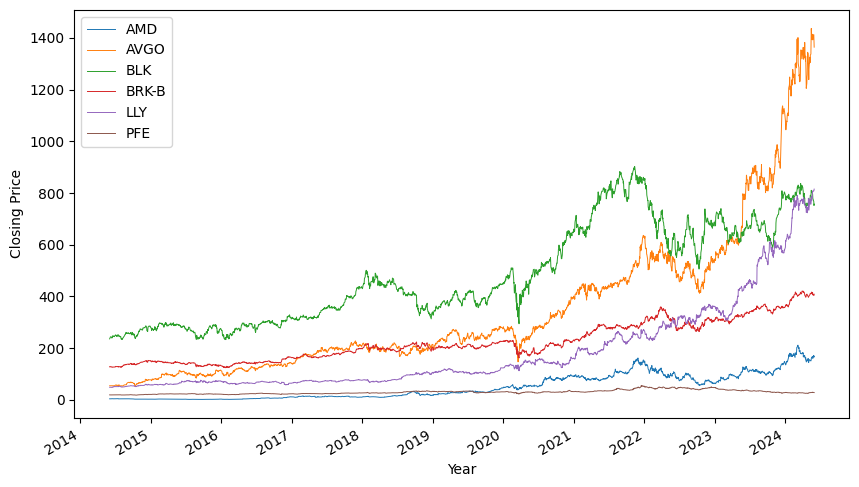

In [4]:
adj_close_data.plot(figsize=(10, 6), linewidth=0.7)
plt.legend()
plt.ylabel('Closing Price')
plt.xlabel('Year')
plt.show()

#### Calcolo dei rendimenti semplici

In [5]:
adjusted_close_returns = adj_close_data.pct_change()
monthly_mean_returns = adjusted_close_returns.groupby(pd.Grouper(freq='ME')).mean()
adjusted_close_returns.dropna(inplace=True)
adjusted_close_returns.head()

Ticker           AMD      AVGO       BLK     BRK-B       LLY       PFE
Date                                                                  
2014-06-03 -0.007557 -0.002652  0.008430 -0.007429 -0.002353 -0.004039
2014-06-04  0.025381  0.002239  0.006934  0.002364 -0.002190  0.001690
2014-06-05  0.009901  0.003631  0.003595  0.007624  0.006079  0.004048
2014-06-06 -0.004902 -0.003340  0.013003  0.003510  0.000839 -0.011425
2014-06-09  0.002463  0.002234  0.001944 -0.005130  0.001845 -0.002379

#### Mostro un grafico con i rendimenti semplici calcolati per azione

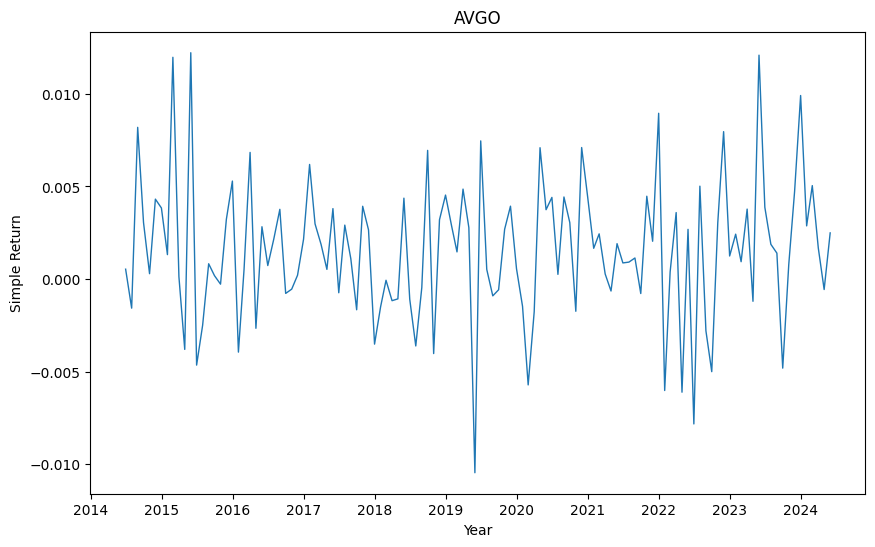

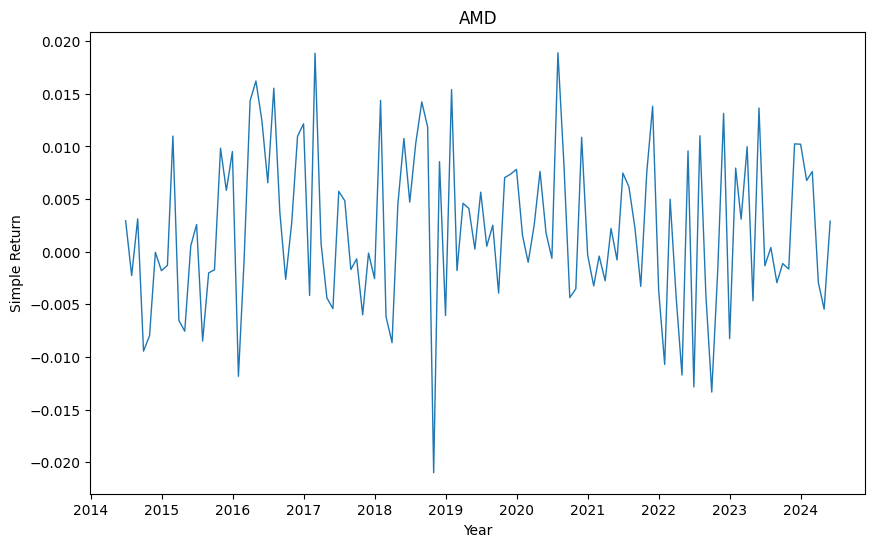

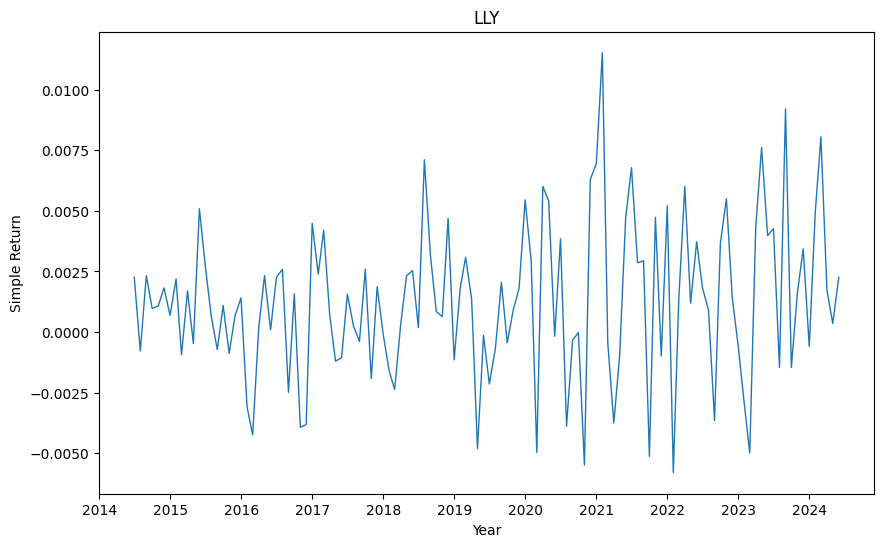

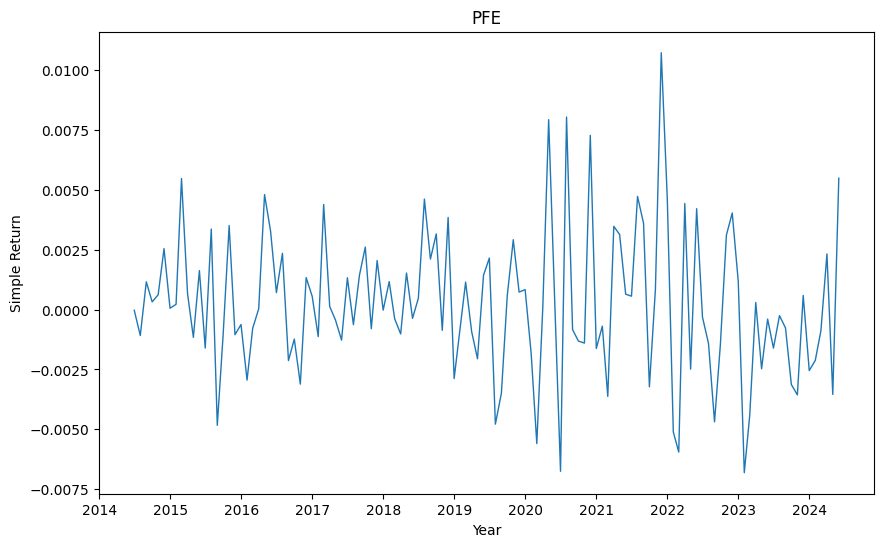

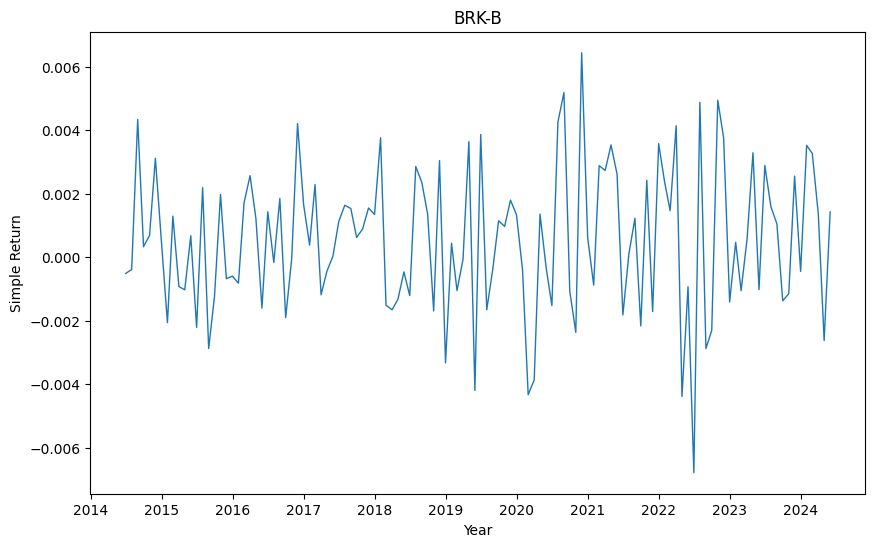

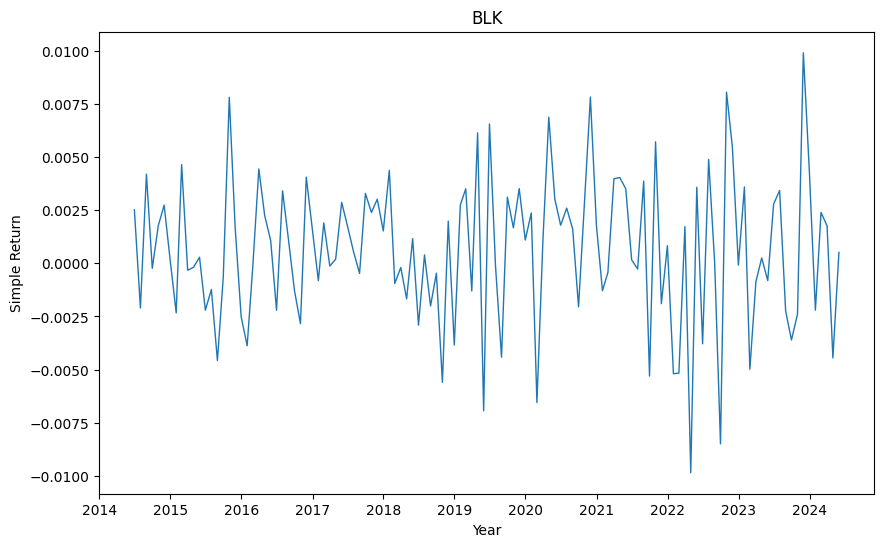

In [6]:
for ticker in selected_stocks:
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_mean_returns[ticker], linewidth=1)
    plt.ylabel('Simple Return')
    plt.xlabel('Year')
    plt.title(ticker)
    plt.show()

#### Calcolo i rendimenti logaritmici

In [7]:
logarithmic_returns = np.log(adj_close_data / adj_close_data.shift(1))
monthly_mean_logarithmic_returns = logarithmic_returns.groupby(pd.Grouper(freq='ME')).mean()
logarithmic_returns.dropna(inplace=True)
logarithmic_returns.head()

Ticker           AMD      AVGO       BLK     BRK-B       LLY       PFE
Date                                                                  
2014-06-03 -0.007585 -0.002656  0.008395 -0.007457 -0.002356 -0.004047
2014-06-04  0.025064  0.002237  0.006910  0.002361 -0.002193  0.001689
2014-06-05  0.009852  0.003625  0.003588  0.007595  0.006061  0.004040
2014-06-06 -0.004914 -0.003345  0.012919  0.003504  0.000839 -0.011490
2014-06-09  0.002460  0.002232  0.001942 -0.005143  0.001843 -0.002382

### Mostro le statistiche sui rendimenti logaritmici

In [8]:
logarithmic_returns.describe()

Ticker          AMD         AVGO          BLK        BRK-B          LLY  \
count   2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean       0.001486     0.001280     0.000463     0.000462     0.001121   
std        0.036220     0.022179     0.017147     0.012110     0.016901   
min       -0.277456    -0.222055    -0.146815    -0.100838    -0.111094   
25%       -0.016697    -0.009964    -0.007751    -0.005321    -0.006760   
50%        0.000586     0.001316     0.000778     0.000481     0.000961   
75%        0.019693     0.012688     0.008739     0.006540     0.008839   
max        0.420617     0.146985     0.126843     0.109840     0.145655   

Ticker          PFE  
count   2516.000000  
mean       0.000152  
std        0.014355  
min       -0.080501  
25%       -0.006726  
50%        0.000000  
75%        0.007011  
max        0.103055

#### Mostro un grafico con i rendimenti logaritmici calcolati per azione

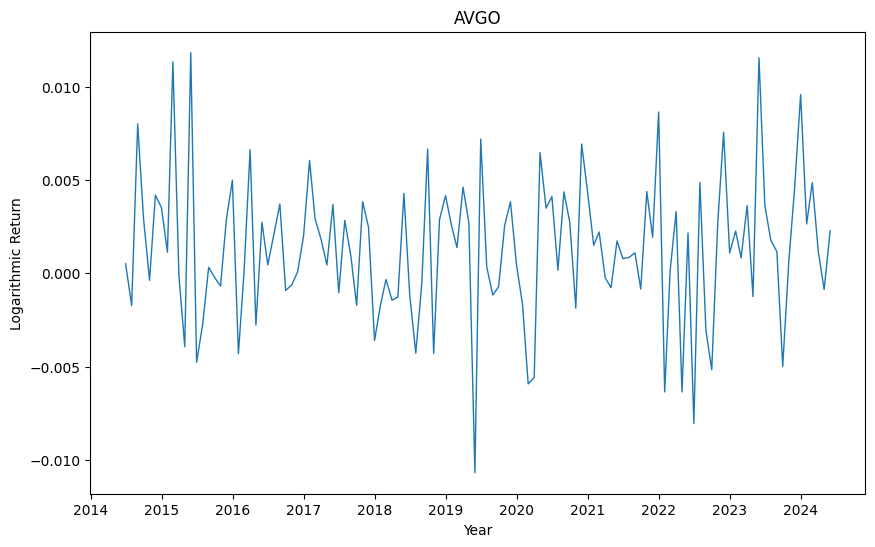

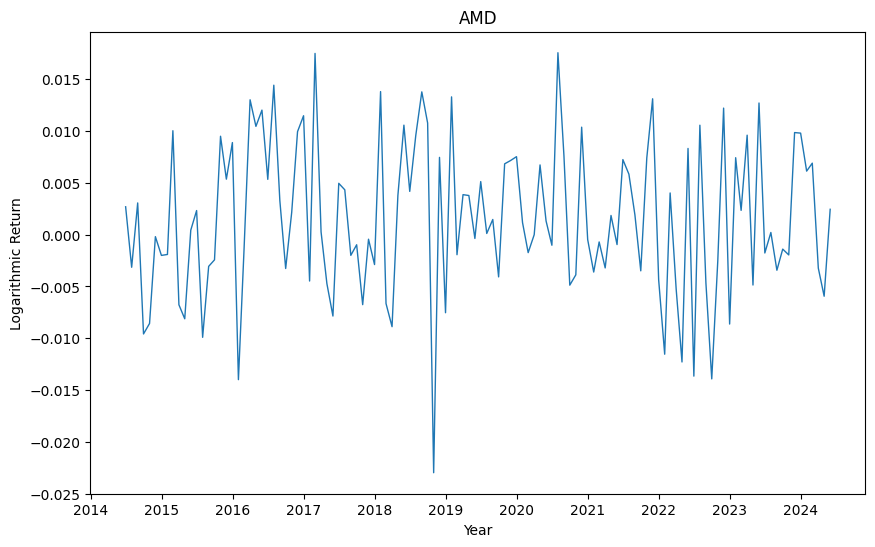

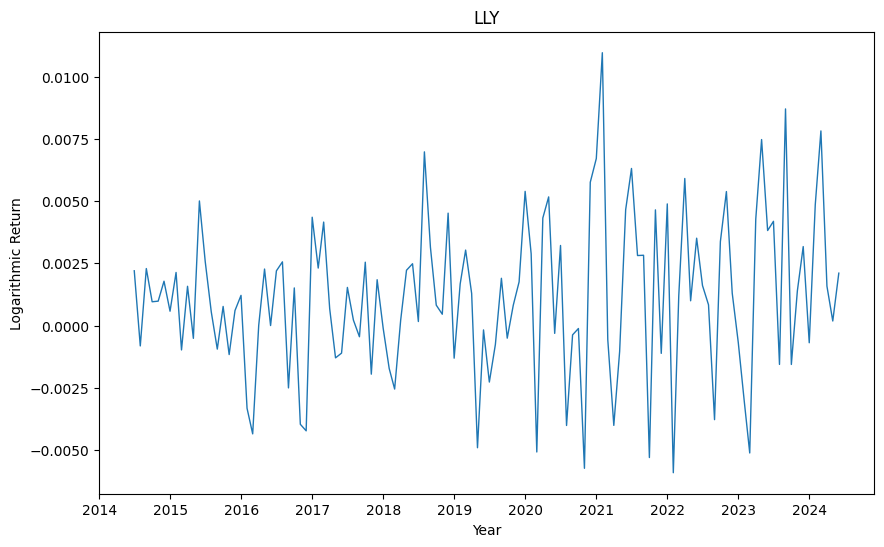

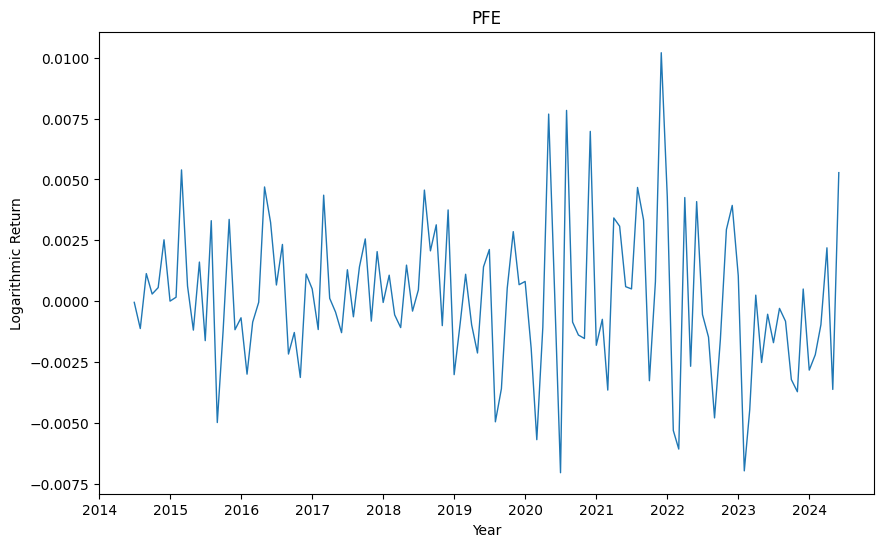

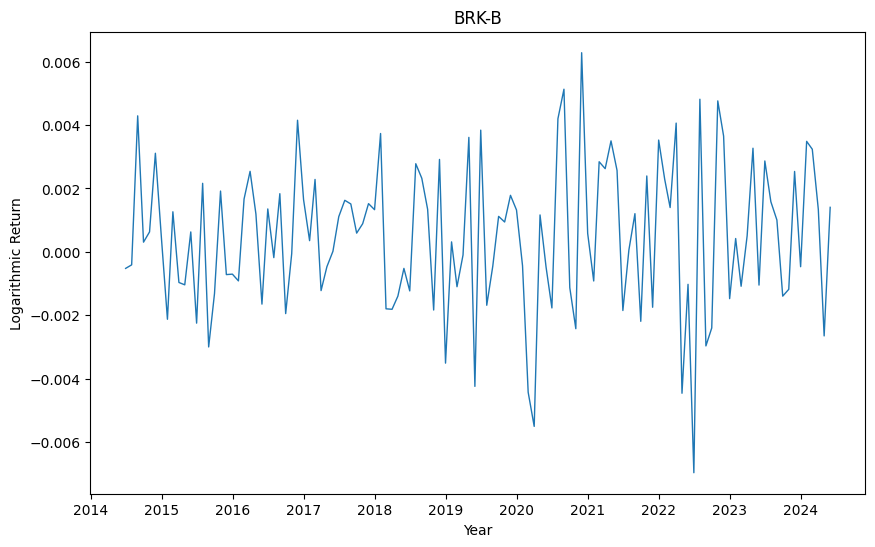

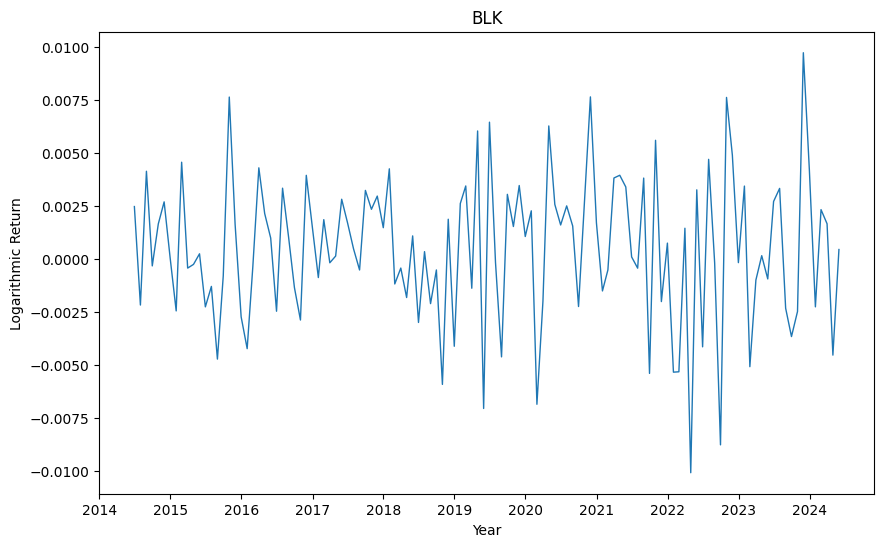

In [9]:
for ticker in selected_stocks:
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_mean_logarithmic_returns[ticker], linewidth=1)
    plt.ylabel('Logarithmic Return')
    plt.xlabel('Year')
    plt.title(ticker)
    plt.show()

#### Calcolo l'aggregazione annuale dei prezzi di chiusura

In [10]:
annual_mean_adj_close = adj_close_data.groupby(pd.Grouper(freq='YE')).mean()

#### Calcolo i rendimenti cumulati annui

In [11]:
cumulative_returns = np.cumprod(1 + adjusted_close_returns)
cumulative_returns.dropna(inplace=True)
print(cumulative_returns)

Ticker            AMD       AVGO       BLK     BRK-B        LLY       PFE
Date                                                                     
2014-06-03   0.992443   0.997348  1.008430  0.992571   0.997647  0.995961
2014-06-04   1.017632   0.999581  1.015423  0.994917   0.995461  0.997644
2014-06-05   1.027708   1.003211  1.019073  1.002502   1.001513  1.001683
2014-06-06   1.022670   0.999860  1.032324  1.006021   1.002353  0.990239
2014-06-09   1.025189   1.002094  1.034330  1.000860   1.004202  0.987883
...               ...        ...       ...       ...        ...       ...
2024-05-23  40.410577  25.573617  3.304237  3.173913  16.644245  1.491575
2024-05-24  41.904282  25.840678  3.293076  3.185877  16.623245  1.501453
2024-05-28  43.226700  25.925294  3.248896  3.158430  16.632097  1.471299
2024-05-29  41.596977  25.525527  3.186438  3.159916  16.707656  1.446344
2024-05-30  42.002519  25.037470  3.208675  3.195261  16.780330  1.466100

[2516 rows x 6 columns]


#### Mostro un grafico con i rendimenti cumulati annui per azioni

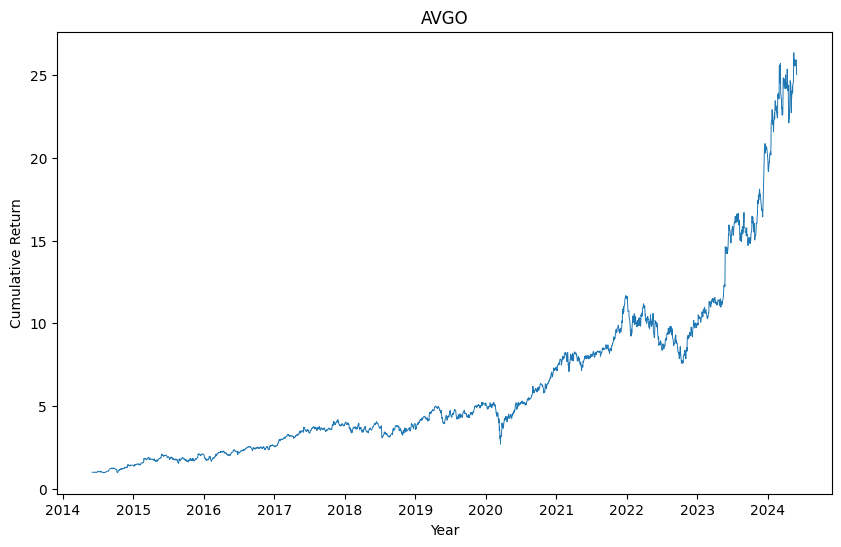

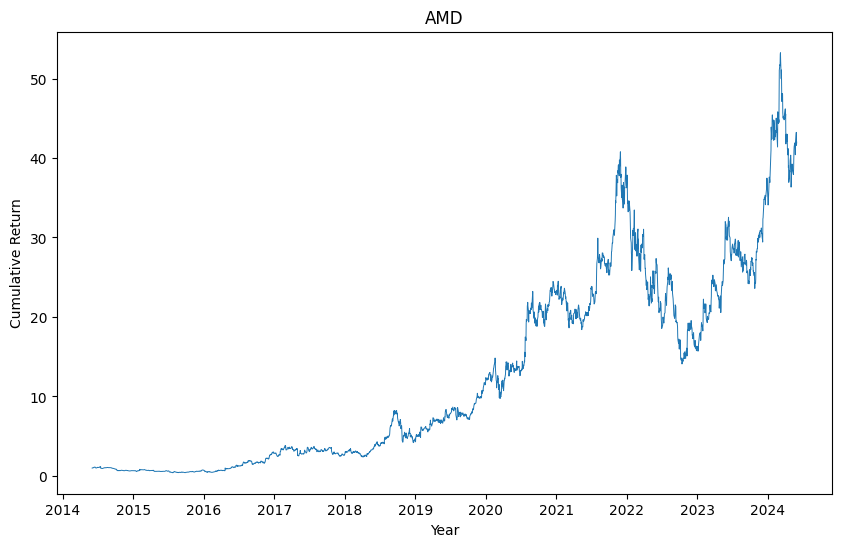

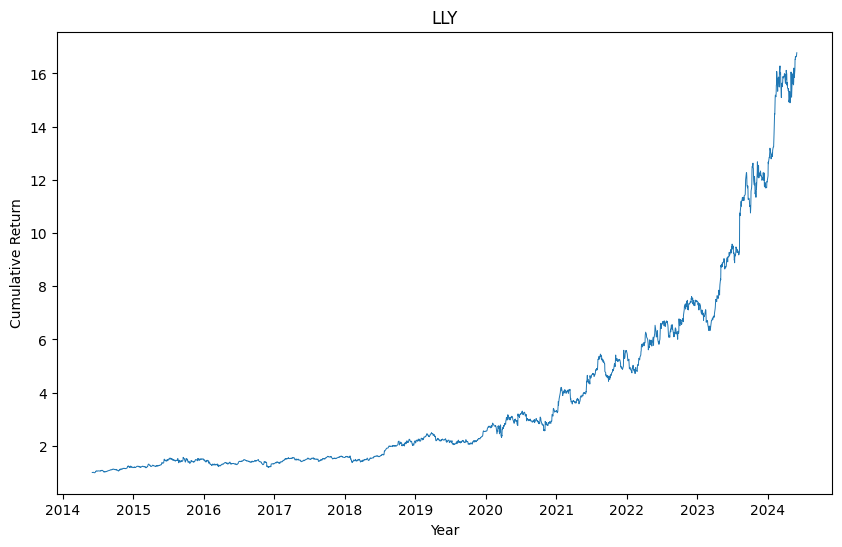

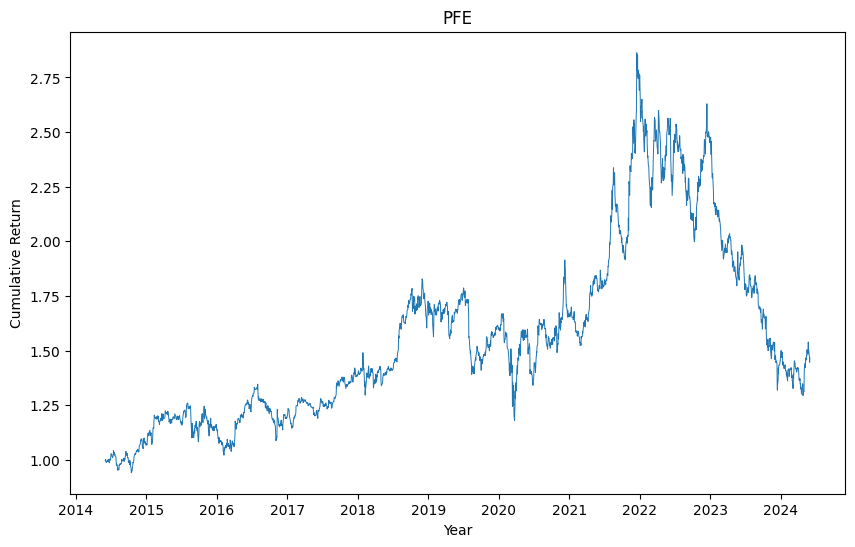

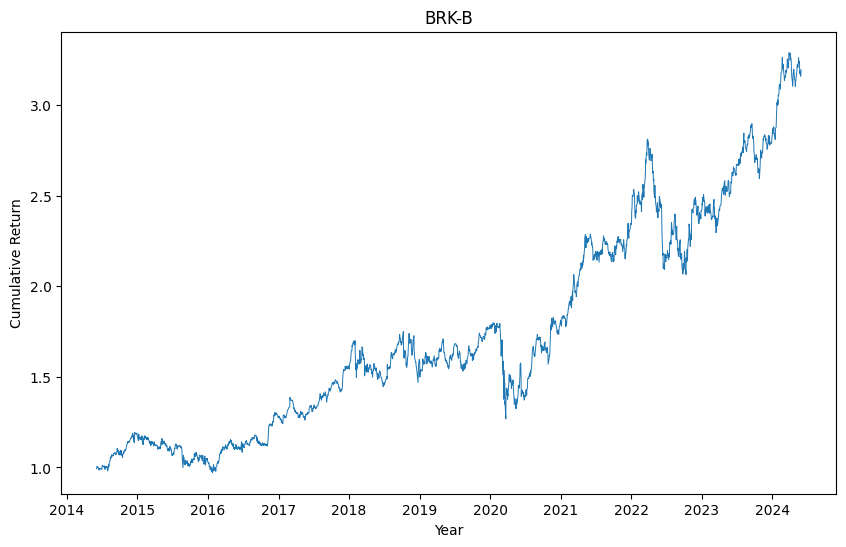

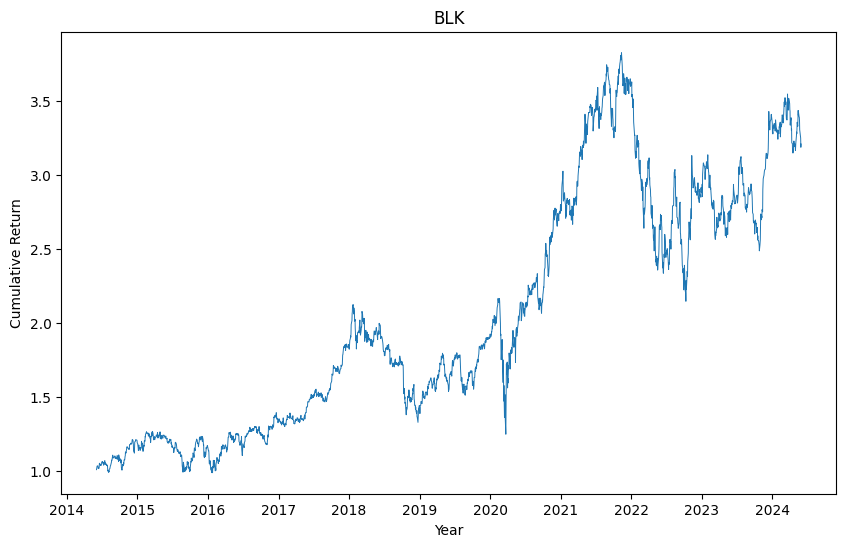

In [12]:
for ticker in selected_stocks:
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns[ticker], linewidth=0.7)
    plt.ylabel('Cumulative Return')
    plt.xlabel('Year')
    plt.title(ticker)
    plt.show()

#### Calcolo i rendimenti composti annui

In [13]:
annual_logarithmic_returns = np.log(annual_mean_adj_close / annual_mean_adj_close.shift(1))
annual_logarithmic_returns.dropna(inplace=True)
annual_logarithmic_returns

Ticker           AMD      AVGO       BLK     BRK-B       LLY       PFE
Date                                                                  
2015-12-31 -0.407161  0.436897  0.071098  0.021573  0.219661  0.147835
2016-12-31  0.812548  0.237190  0.034775  0.027320 -0.005471  0.008661
2017-12-31  0.859473  0.425109  0.215937  0.195258  0.099625  0.075622
2018-12-31  0.327115  0.044281  0.172233  0.150505  0.157014  0.176448
2019-12-31  0.553479  0.225337 -0.065386  0.022084  0.240586  0.053604
2020-12-31  0.784645  0.158157  0.249153 -0.014826  0.265549 -0.041021
2021-12-31  0.432687  0.462506  0.437091  0.285351  0.430090  0.228561
2022-12-31 -0.106940  0.119425 -0.184594  0.110225  0.328184  0.199031
2023-12-31  0.125390  0.400170  0.035327  0.096150  0.424518 -0.264781
2024-12-31  0.494684  0.502737  0.155358  0.175223  0.463164 -0.253682

#### Mostro le informazioni sui rendimenti logaritmici

In [14]:
logarithmic_returns.describe()

Ticker          AMD         AVGO          BLK        BRK-B          LLY  \
count   2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean       0.001486     0.001280     0.000463     0.000462     0.001121   
std        0.036220     0.022179     0.017147     0.012110     0.016901   
min       -0.277456    -0.222055    -0.146815    -0.100838    -0.111094   
25%       -0.016697    -0.009964    -0.007751    -0.005321    -0.006760   
50%        0.000586     0.001316     0.000778     0.000481     0.000961   
75%        0.019693     0.012688     0.008739     0.006540     0.008839   
max        0.420617     0.146985     0.126843     0.109840     0.145655   

Ticker          PFE  
count   2516.000000  
mean       0.000152  
std        0.014355  
min       -0.080501  
25%       -0.006726  
50%        0.000000  
75%        0.007011  
max        0.103055

#### Mostro le informazioni sui rendimenti semplici

In [15]:
adjusted_close_returns.describe()

Ticker          AMD         AVGO          BLK        BRK-B          LLY  \
count   2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean       0.002148     0.001526     0.000610     0.000535     0.001265   
std        0.036785     0.022139     0.017148     0.012104     0.017044   
min       -0.242291    -0.199129    -0.136546    -0.095921    -0.105145   
25%       -0.016559    -0.009914    -0.007721    -0.005307    -0.006737   
50%        0.000586     0.001316     0.000779     0.000481     0.000962   
75%        0.019888     0.012769     0.008777     0.006561     0.008879   
max        0.522901     0.158337     0.135239     0.116099     0.156798   

Ticker          PFE  
count   2516.000000  
mean       0.000255  
std        0.014380  
min       -0.077346  
25%       -0.006703  
50%        0.000000  
75%        0.007036  
max        0.108552

#### Mostro un istogramma dei rendimenti logaritmici

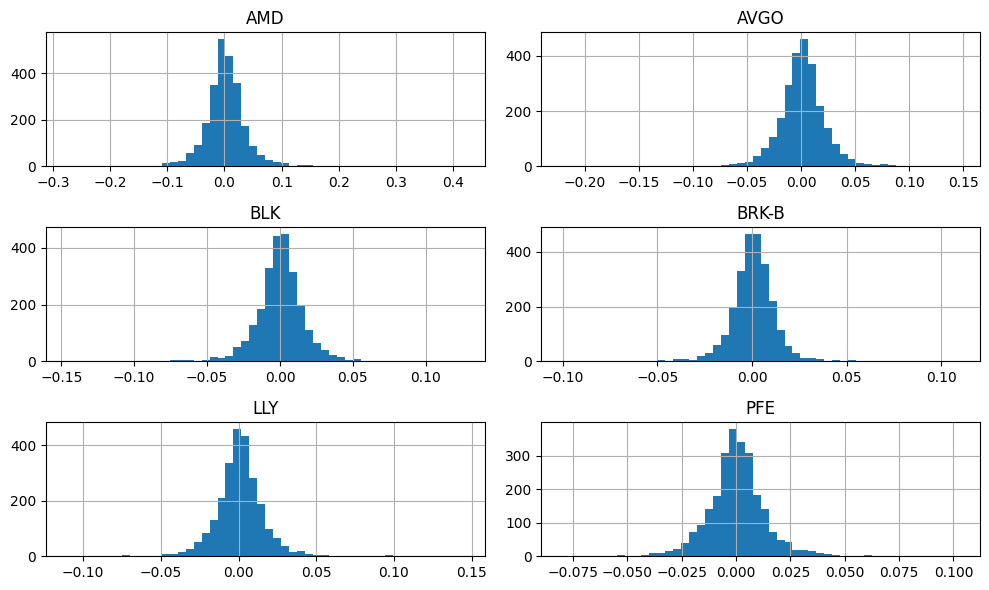

In [16]:
logarithmic_returns.hist(bins=50, figsize=(10, 6))
plt.tight_layout()
plt.show()

#### Mostro un grafico a dispersione dei rendimenti logaritmici dei titoli tecnologici
- Broadcom: AVGO
- Advanced Micro Devices: AMD

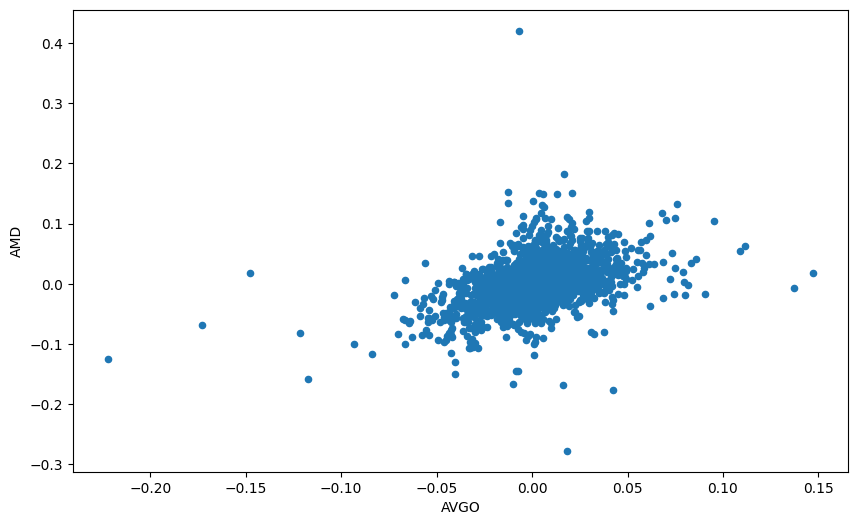

In [17]:
logarithmic_returns.plot(kind='scatter', x='AVGO', y='AMD', figsize=(10, 6))
plt.show()

#### Mostro un grafico a dispersione dei rendimenti logaritmici dei titoli sanitari
- Eli Lilly: LLY
- Pfizer: PFE

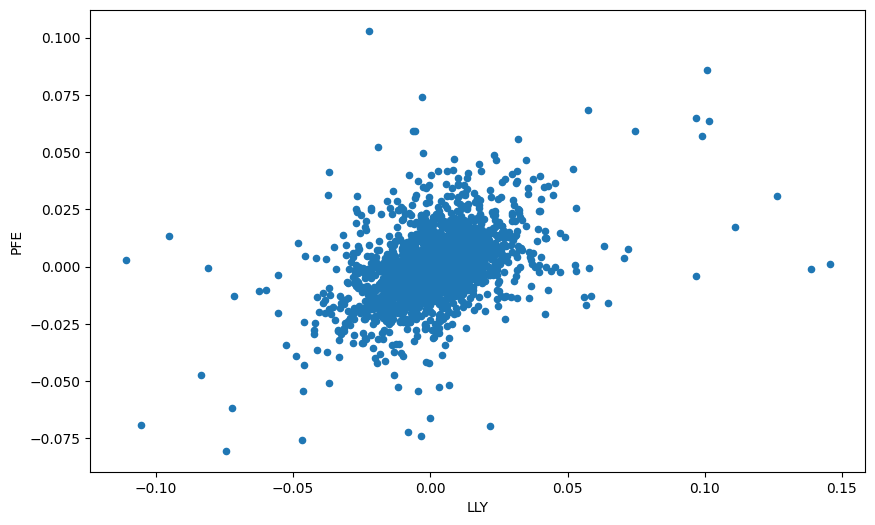

In [18]:
logarithmic_returns.plot(kind='scatter', x='LLY', y='PFE', figsize=(10, 6))
plt.show()

#### Mostro un grafico a dispersione dei rendimenti logaritmici dei titoli finanziari
- Berkshire Hathaway: BRK-B
- Blackrock: BLK

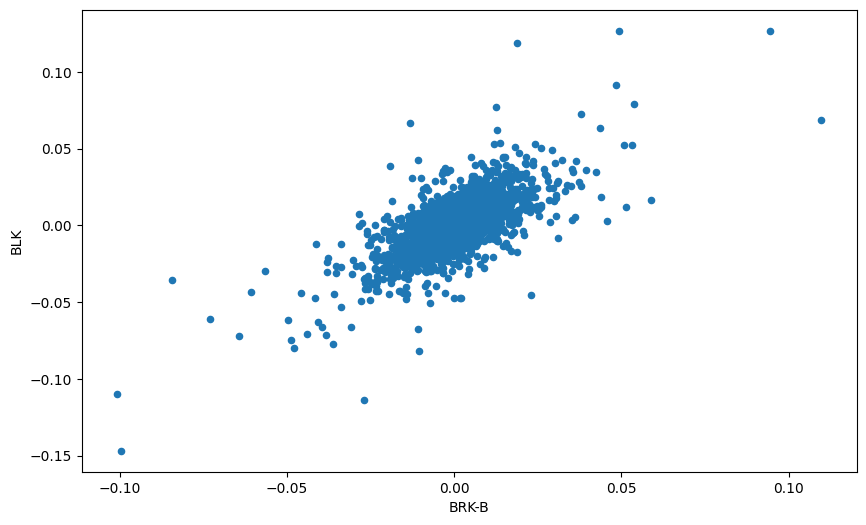

In [19]:
logarithmic_returns.plot(kind='scatter', x='BRK-B', y='BLK', figsize=(10, 6))
plt.show()

#### Mostro i grafici a densita dei rendimenti logaritmici per titolo

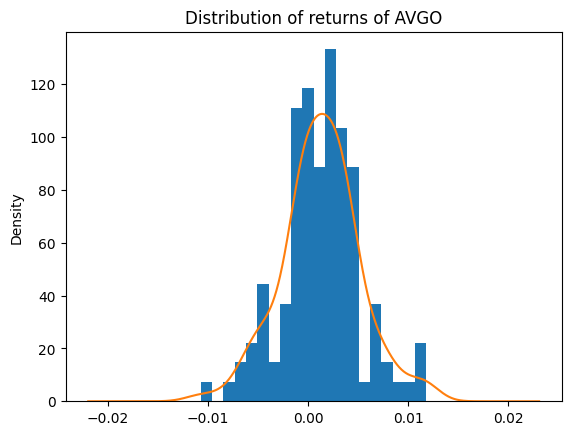

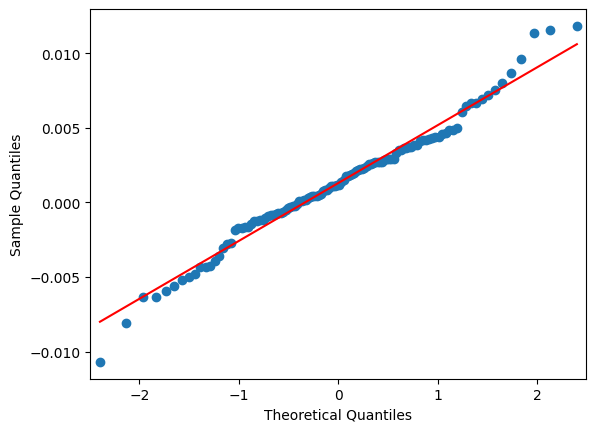

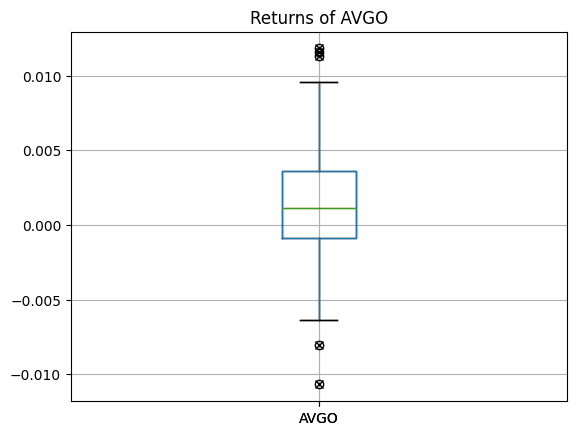

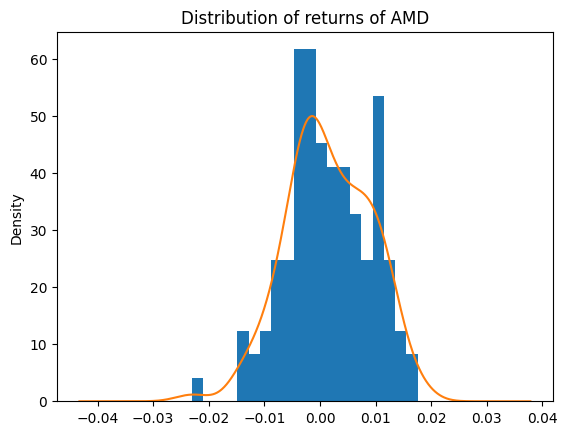

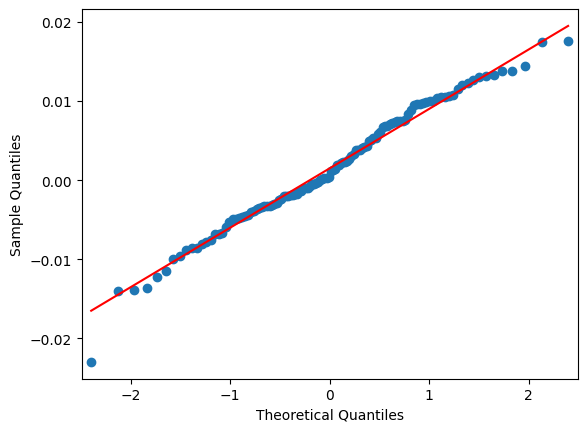

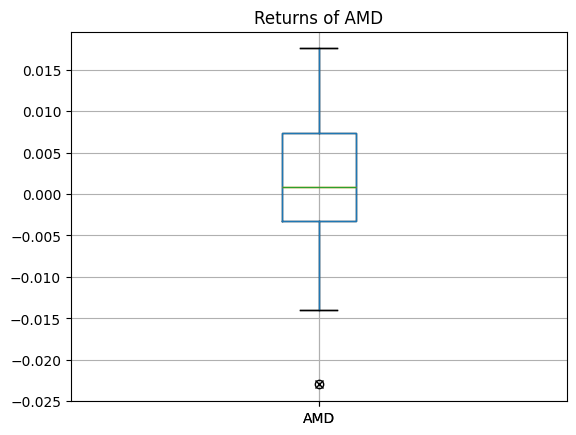

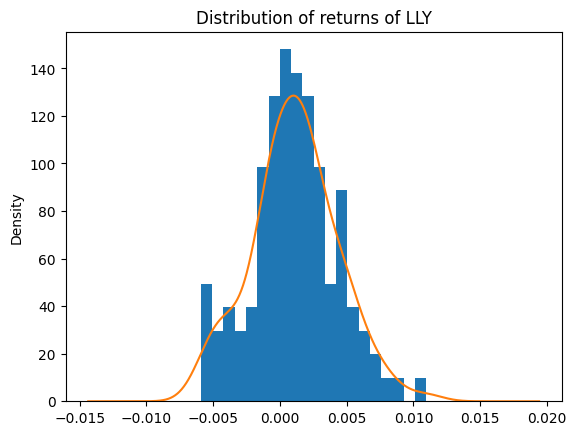

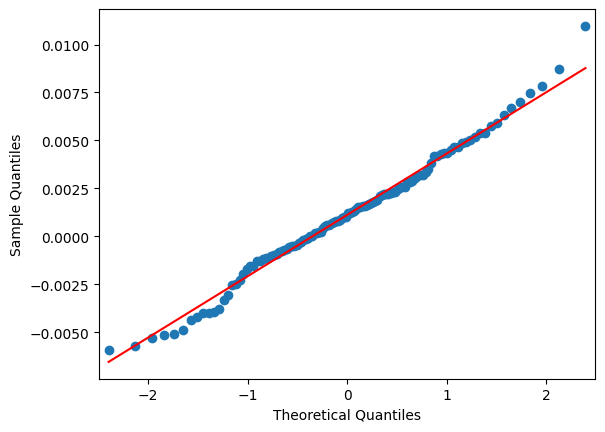

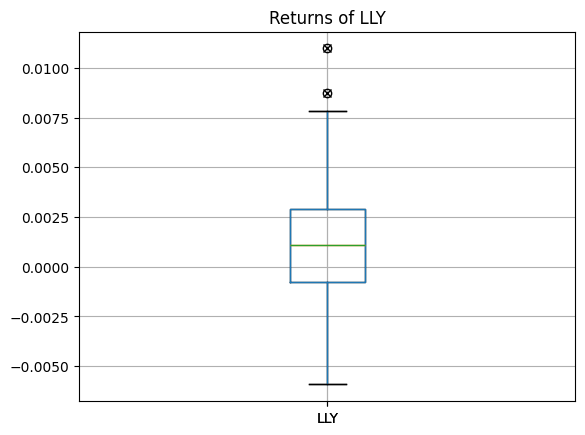

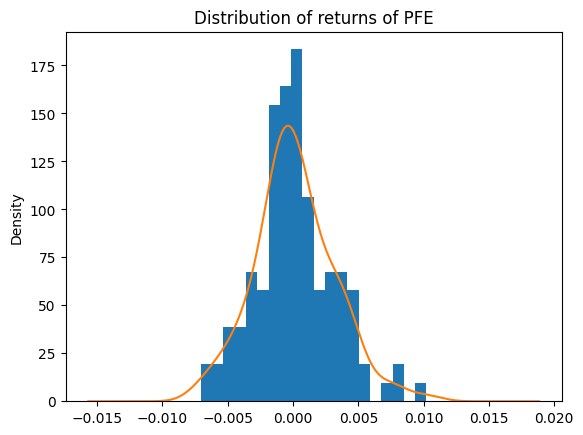

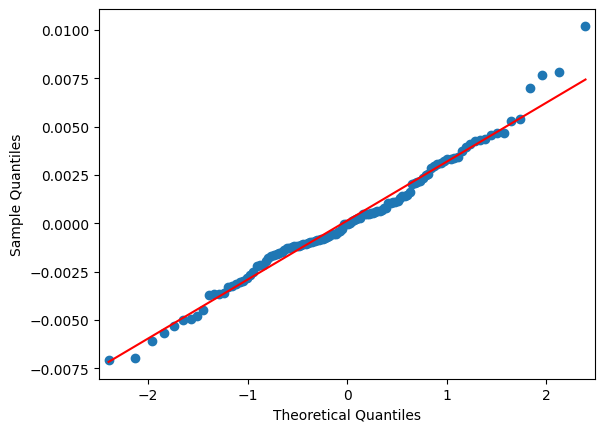

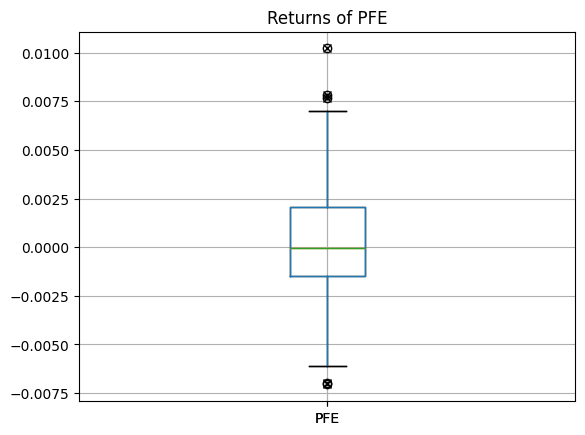

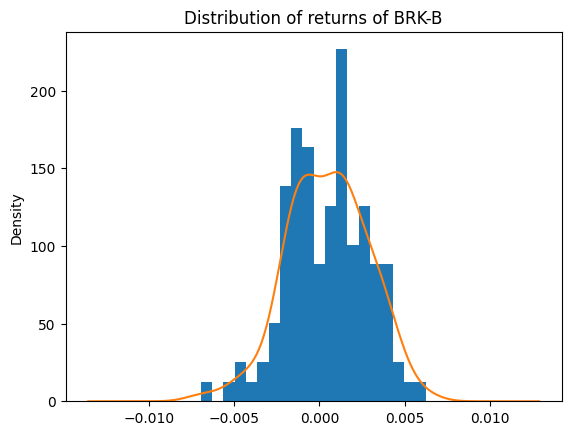

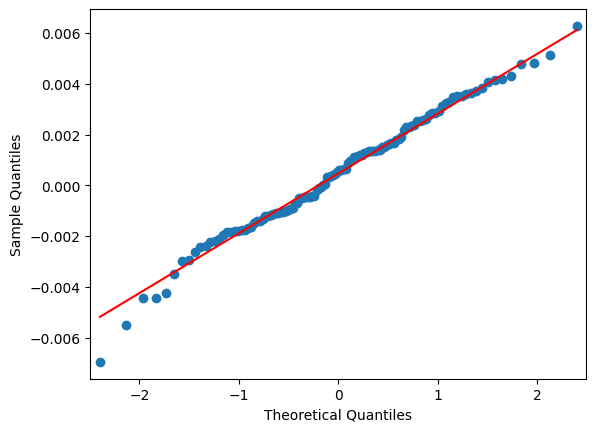

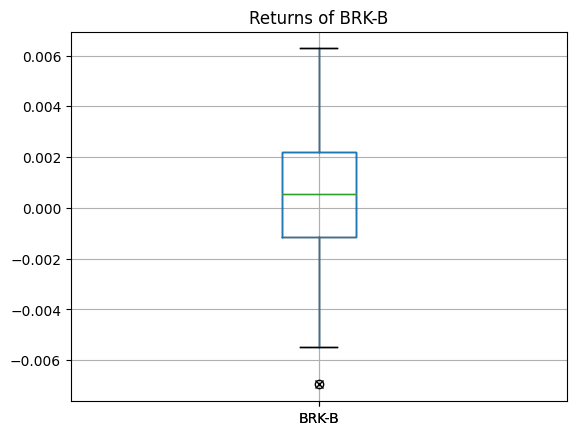

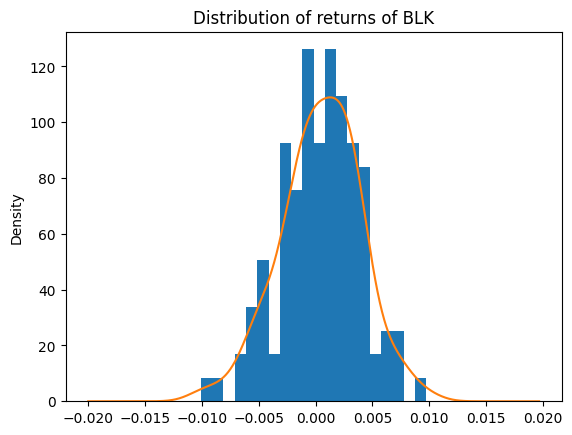

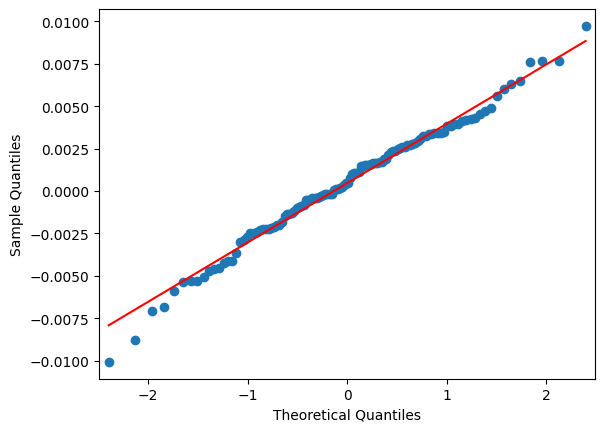

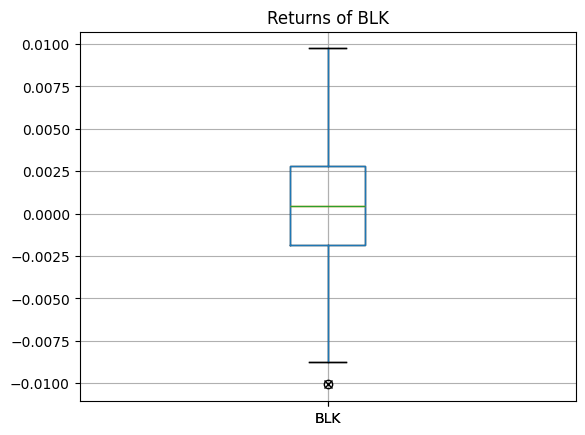

In [20]:
for ticker in selected_stocks:
    plt.figure()
    plt.hist(monthly_mean_logarithmic_returns[ticker], density = True, bins=20)
    plt.title('Distribution of returns of {}'.format(ticker))
    monthly_mean_logarithmic_returns[ticker].plot.density()

    sm.qqplot(monthly_mean_logarithmic_returns[ticker], line = 's')

    plt.figure()
    plt.boxplot(monthly_mean_logarithmic_returns[ticker], sym = 'x')
    plt.title('Returns of {}'.format(ticker))
    monthly_mean_logarithmic_returns[ticker].to_frame().boxplot()

plt.show()

#### Calcolo le statistiche descrittive univariate
- Media
- Varianza
- Deviazione Standard
- Asimmetria
- Curtosi

In [21]:
for ticker in selected_stocks:
    mean_return = round(logarithmic_returns[ticker].mean(), 4)
    variance_return = round(logarithmic_returns[ticker].var(), 4)
    std_deviation_return = round(logarithmic_returns[ticker].std(), 4)
    skewness_return = round(logarithmic_returns[ticker].skew(), 4)
    kurtosis_return = round(logarithmic_returns[ticker].kurtosis(), 4)
    
    print(f"Ticker: {ticker}")
    print(f"Average: {mean_return}")
    print(f"Variance: {variance_return}")
    print(f"Standard Deviation: {std_deviation_return}")
    print(f"Skew: {skewness_return}")
    print(f"Kurtosis: {kurtosis_return}")
    print()

Ticker: AVGO
Average: 0.0013
Variance: 0.0005
Standard Deviation: 0.0222
Skew: -0.4277
Kurtosis: 9.3448

Ticker: AMD
Average: 0.0015
Variance: 0.0013
Standard Deviation: 0.0362
Skew: 0.4757
Kurtosis: 10.6656

Ticker: LLY
Average: 0.0011
Variance: 0.0003
Standard Deviation: 0.0169
Skew: 0.7396
Kurtosis: 10.7269

Ticker: PFE
Average: 0.0002
Variance: 0.0002
Standard Deviation: 0.0144
Skew: 0.1503
Kurtosis: 5.1215

Ticker: BRK-B
Average: 0.0005
Variance: 0.0001
Standard Deviation: 0.0121
Skew: -0.2482
Kurtosis: 11.2449

Ticker: BLK
Average: 0.0005
Variance: 0.0003
Standard Deviation: 0.0171
Skew: -0.1606
Kurtosis: 8.7427



#### Calcolo la correlazione tra i rendimenti logaritmici dei titoli tecnologici

In [22]:
it_sector_correlation = logarithmic_returns['AMD'].corr(logarithmic_returns['AVGO'])
print(f"IT Sector Correlation: {it_sector_correlation}")

IT Sector Correlation: 0.44695945683237637


#### Calcolo la correlazione tra i rendimenti logaritmici dei titoli sanitari

In [23]:
healthcare_sector_correlation = logarithmic_returns['PFE'].corr(logarithmic_returns['LLY'])
print(f"Healthcare Sector Correlation: {healthcare_sector_correlation}")

Healthcare Sector Correlation: 0.43407863351475034


#### Calcolo la correlazione tra i rendimenti logaritmici dei titoli finanziari

In [24]:
finance_sector_correlation = logarithmic_returns['BLK'].corr(logarithmic_returns['BRK-B'])
print(f"Finance Sector Correlation: {finance_sector_correlation}")

Finance Sector Correlation: 0.7064243596862642


#### Calcolo matrice di covarianza

In [25]:
covariance_matrix = logarithmic_returns.cov()
print(covariance_matrix)

Ticker       AMD      AVGO       BLK     BRK-B       LLY       PFE
Ticker                                                            
AMD     0.001312  0.000359  0.000233  0.000137  0.000104  0.000093
AVGO    0.000359  0.000492  0.000207  0.000130  0.000094  0.000081
BLK     0.000233  0.000207  0.000294  0.000147  0.000094  0.000099
BRK-B   0.000137  0.000130  0.000147  0.000147  0.000076  0.000081
LLY     0.000104  0.000094  0.000094  0.000076  0.000286  0.000105
PFE     0.000093  0.000081  0.000099  0.000081  0.000105  0.000206


#### Calcolo matrice di correlazione

In [26]:
correlation_matrix = logarithmic_returns.corr()
print(correlation_matrix)

Ticker       AMD      AVGO       BLK     BRK-B       LLY       PFE
Ticker                                                            
AMD     1.000000  0.446959  0.374661  0.312397  0.169330  0.178133
AVGO    0.446959  1.000000  0.543171  0.485652  0.251777  0.255830
BLK     0.374661  0.543171  1.000000  0.706424  0.325222  0.403830
BRK-B   0.312397  0.485652  0.706424  1.000000  0.368904  0.463404
LLY     0.169330  0.251777  0.325222  0.368904  1.000000  0.434079
PFE     0.178133  0.255830  0.403830  0.463404  0.434079  1.000000


#### Calcolo correlazione nel tempo per ogni settore

In [27]:
it_sector_correlation_over_time = logarithmic_returns['AMD'].rolling(window=90).corr(logarithmic_returns['AVGO'])
healthcare_sector_correlation_over_time = logarithmic_returns['PFE'].rolling(window=90).corr(logarithmic_returns['LLY'])
finance_sector_correlation_over_time = logarithmic_returns['BLK'].rolling(window=90).corr(logarithmic_returns['BRK-B'])

#### Mostro grafico correlazione nel tempo per il settore tecnologico

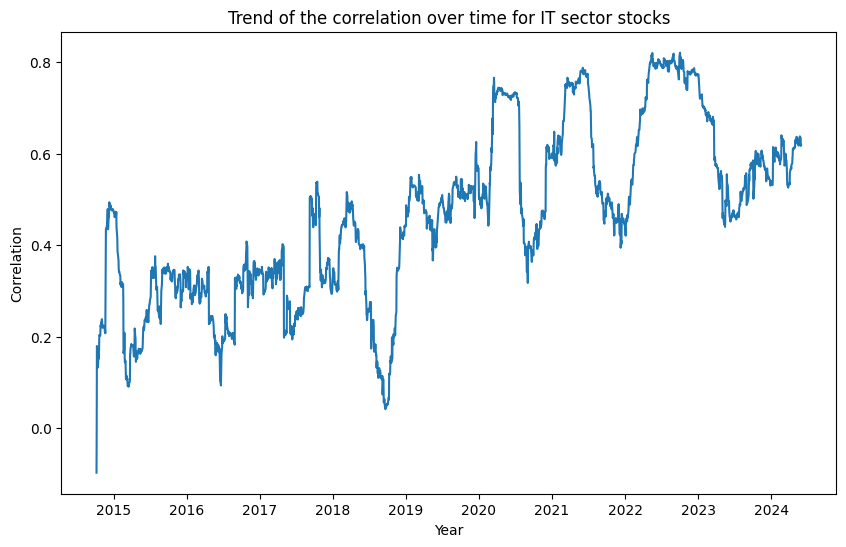

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(it_sector_correlation_over_time.index, it_sector_correlation_over_time)
ax.set_xlabel('Year')
ax.set_ylabel('Correlation')
ax.set_title('Trend of the correlation over time for IT sector stocks')
plt.show()

#### Mostro grafico correlazione nel tempo per il settore sanitario

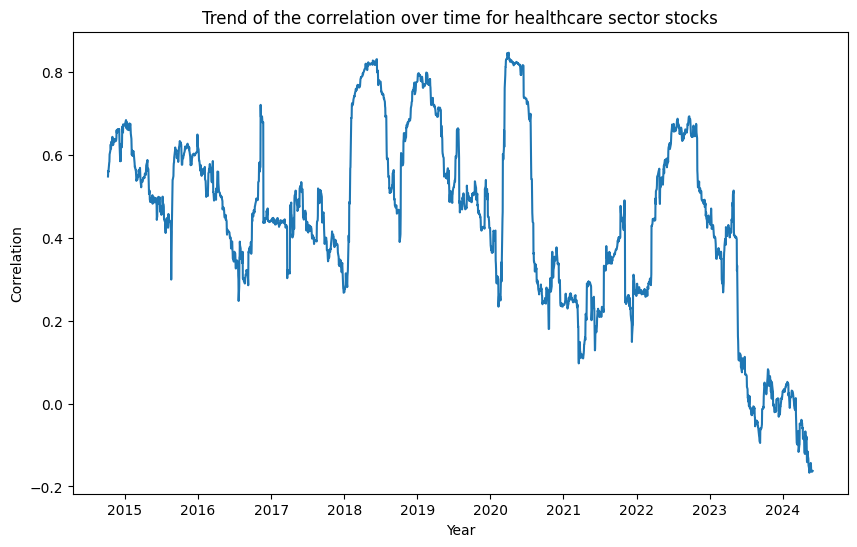

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(healthcare_sector_correlation_over_time.index, healthcare_sector_correlation_over_time)
ax.set_xlabel('Year')
ax.set_ylabel('Correlation')
ax.set_title('Trend of the correlation over time for healthcare sector stocks')
plt.show()

#### Mostro grafico correlazione nel tempo per il settore bancario

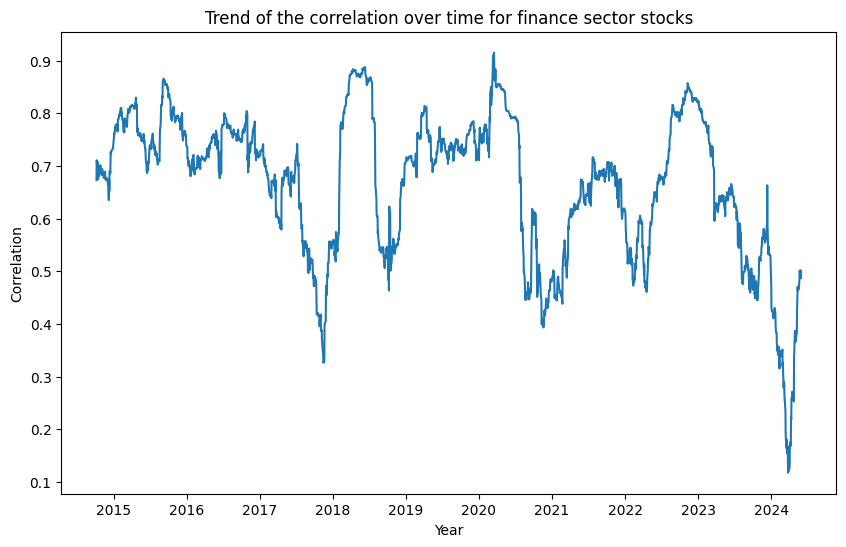

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(finance_sector_correlation_over_time.index, finance_sector_correlation_over_time)
ax.set_xlabel('Year')
ax.set_ylabel('Correlation')
ax.set_title('Trend of the correlation over time for finance sector stocks')
plt.show()

#### Calcolo delle correlazione medie

In [31]:
mean_correlation = correlation_matrix.mean()

#### Mostro il grafico di dispersione delle correlazione medie tra i titoli tecnologici

Text(0, 0.5, 'AMD')

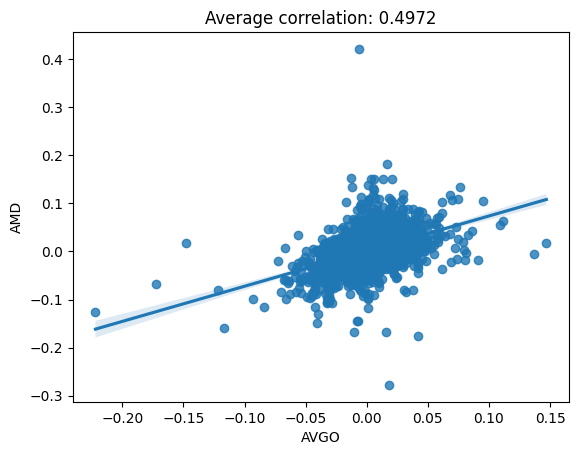

In [32]:
plt.figure()
sns.regplot(x=logarithmic_returns['AVGO'], y=logarithmic_returns['AMD'], data=logarithmic_returns)
plt.title("Average correlation: " + str(round(mean_correlation['AVGO'], 4)))
plt.xlabel('AVGO')
plt.ylabel('AMD')

#### Mostro il grafico di dispersione delle correlazione medie tra i titoli sanitari

Text(0, 0.5, 'PFE')

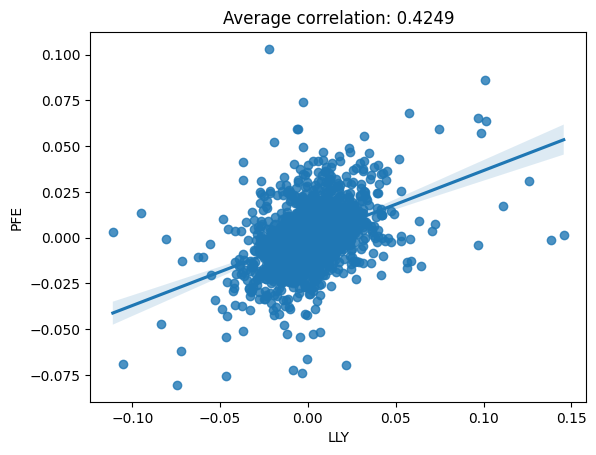

In [33]:
plt.figure()
sns.regplot(x=logarithmic_returns['LLY'], y=logarithmic_returns['PFE'], data=logarithmic_returns)
plt.title("Average correlation: " + str(round(mean_correlation['LLY'], 4)))
plt.xlabel('LLY')
plt.ylabel('PFE')

#### Mostro il grafico di dispersione delle correlazione medie tra i titoli bancari

Text(0, 0.5, 'BLK')

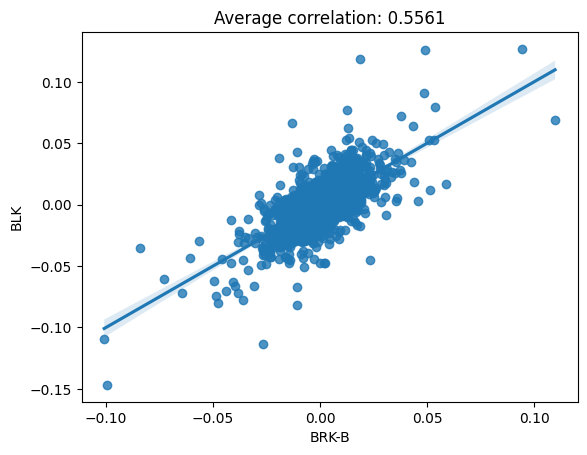

In [34]:
plt.figure()
sns.regplot(x=logarithmic_returns['BRK-B'], y=logarithmic_returns['BLK'], data=logarithmic_returns)
plt.title("Average correlation: " + str(round(mean_correlation['BRK-B'], 4)))
plt.xlabel('BRK-B')
plt.ylabel('BLK')

#### Calcolo il forecast a 5 giorni

In [35]:
forecast_days = 5
for ticker in selected_stocks:
    column_position = adj_close_data.columns.get_loc(ticker) + 1
    adj_close_data.insert(
        column_position,
        f"{ticker}_5_Days_Price_Forecast",
        adj_close_data[ticker].shift(-forecast_days)
    )

print(adj_close_data.head(12))

Ticker       AMD  AMD_5_Days_Price_Forecast       AVGO  \
Date                                                     
2014-06-02  3.97                       4.07  54.481541   
2014-06-03  3.94                       4.20  54.337036   
2014-06-04  4.04                       4.29  54.458706   
2014-06-05  4.08                       4.29  54.656456   
2014-06-06  4.06                       4.28  54.473919   
2014-06-09  4.07                       4.44  54.595631   
2014-06-10  4.20                       4.47  54.648830   
2014-06-11  4.29                       4.40  54.565182   
2014-06-12  4.29                       4.36  54.572784   
2014-06-13  4.28                       4.10  54.314213   
2014-06-16  4.44                       4.01  53.903557   
2014-06-17  4.47                       3.94  54.583183   

Ticker      AVGO_5_Days_Price_Forecast         BLK  BLK_5_Days_Price_Forecast  \
Date                                                                            
2014-06-02               

#### Divido il dataset in base ai titoli

In [36]:
adj_close_forecasts = [
    adj_close_data[[ticker, f"{ticker}_5_Days_Price_Forecast"]]
    for ticker in selected_stocks
]

print(adj_close_forecasts)

[Ticker             AVGO  AVGO_5_Days_Price_Forecast
Date                                               
2014-06-02    54.481541                   54.595631
2014-06-03    54.337036                   54.648830
2014-06-04    54.458706                   54.565182
2014-06-05    54.656456                   54.572784
2014-06-06    54.473919                   54.314213
...                 ...                         ...
2024-05-23  1393.290039                         NaN
2024-05-24  1407.839966                         NaN
2024-05-28  1412.449951                         NaN
2024-05-29  1390.670044                         NaN
2024-05-30  1364.079956                         NaN

[2517 rows x 2 columns], Ticker             AMD  AMD_5_Days_Price_Forecast
Date                                             
2014-06-02    3.970000                       4.07
2014-06-03    3.940000                       4.20
2014-06-04    4.040000                       4.29
2014-06-05    4.080000                       4.

#### Ritorno la forma dell'array (numero di elementi in ogni dimensione)

In [37]:
print(adj_close_forecasts[0].shape)

(2517, 2)


#### Analisi e grafico per ogni titolo del dataset

[*********************100%%**********************]  6 of 6 completed


SVM model confidence score for AVGO: 0.9309357373334644
Mean Absolute Error for AVGO: 17.098402559903455
Mean Squared Error for AVGO: 468.49933752317145
R2 Score for AVGO: 0.9020057684693716
0.9309357373334644


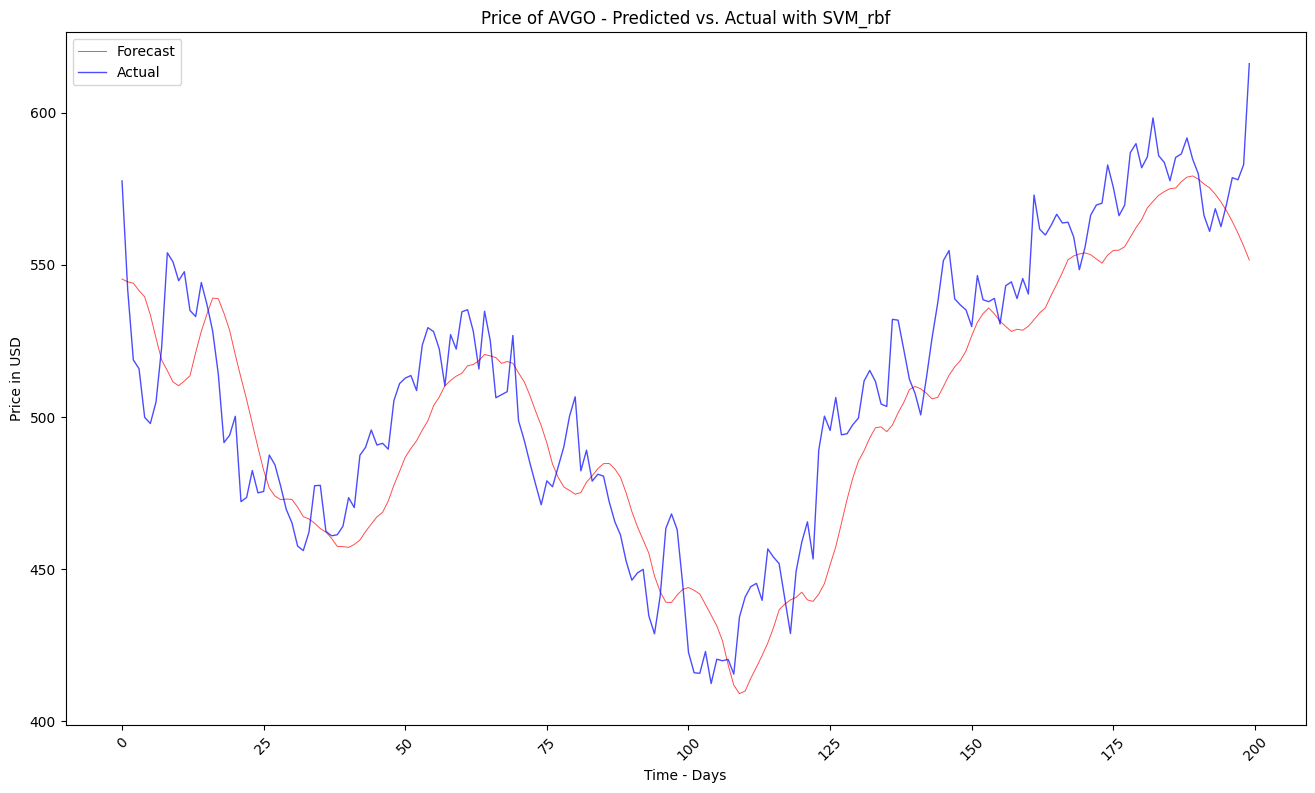

SVM model confidence score for AMD: 0.9295317141583804
Mean Absolute Error for AMD: 5.252784451862971
Mean Squared Error for AMD: 47.571228788361566
R2 Score for AMD: 0.9002271303214141
0.9295317141583804


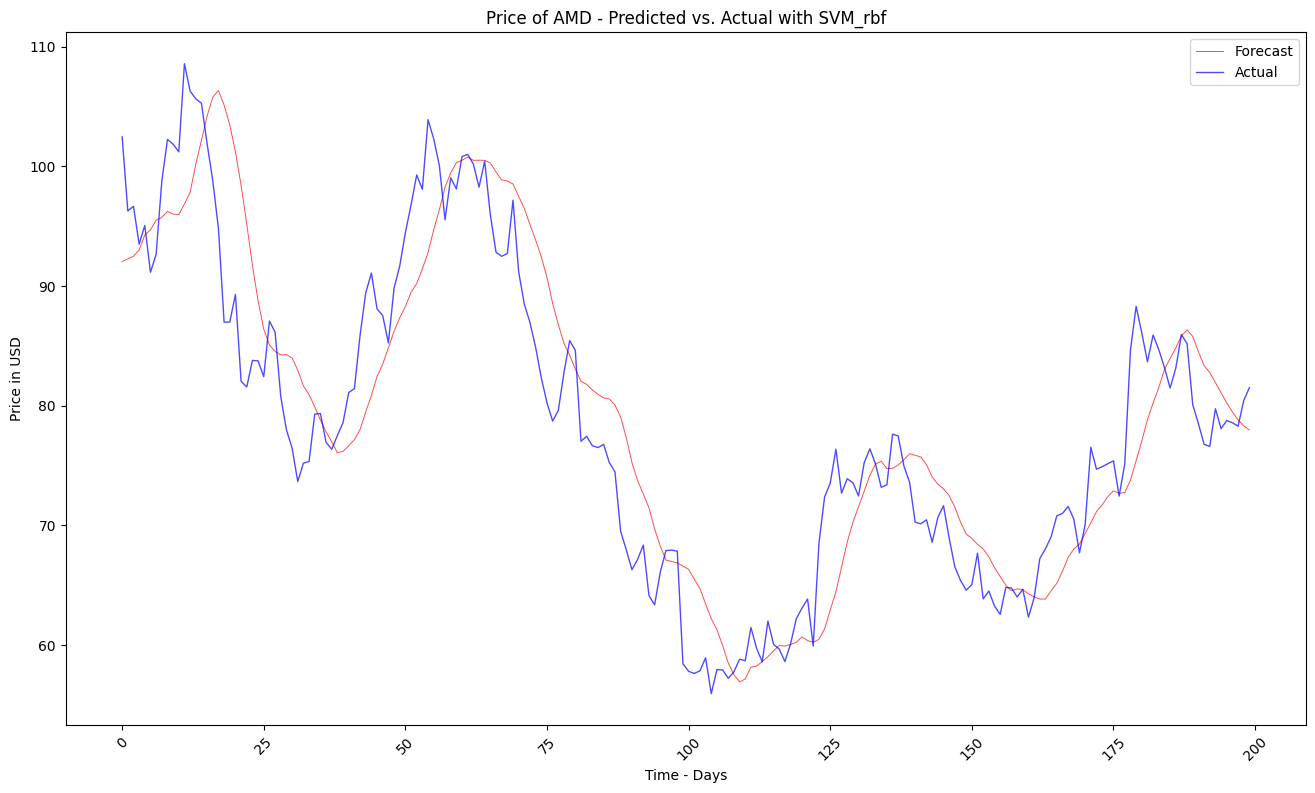

SVM model confidence score for LLY: 0.9203654052400172
Mean Absolute Error for LLY: 8.293077427277545
Mean Squared Error for LLY: 115.44470118646156
R2 Score for LLY: 0.9720466435497603
0.9203654052400172


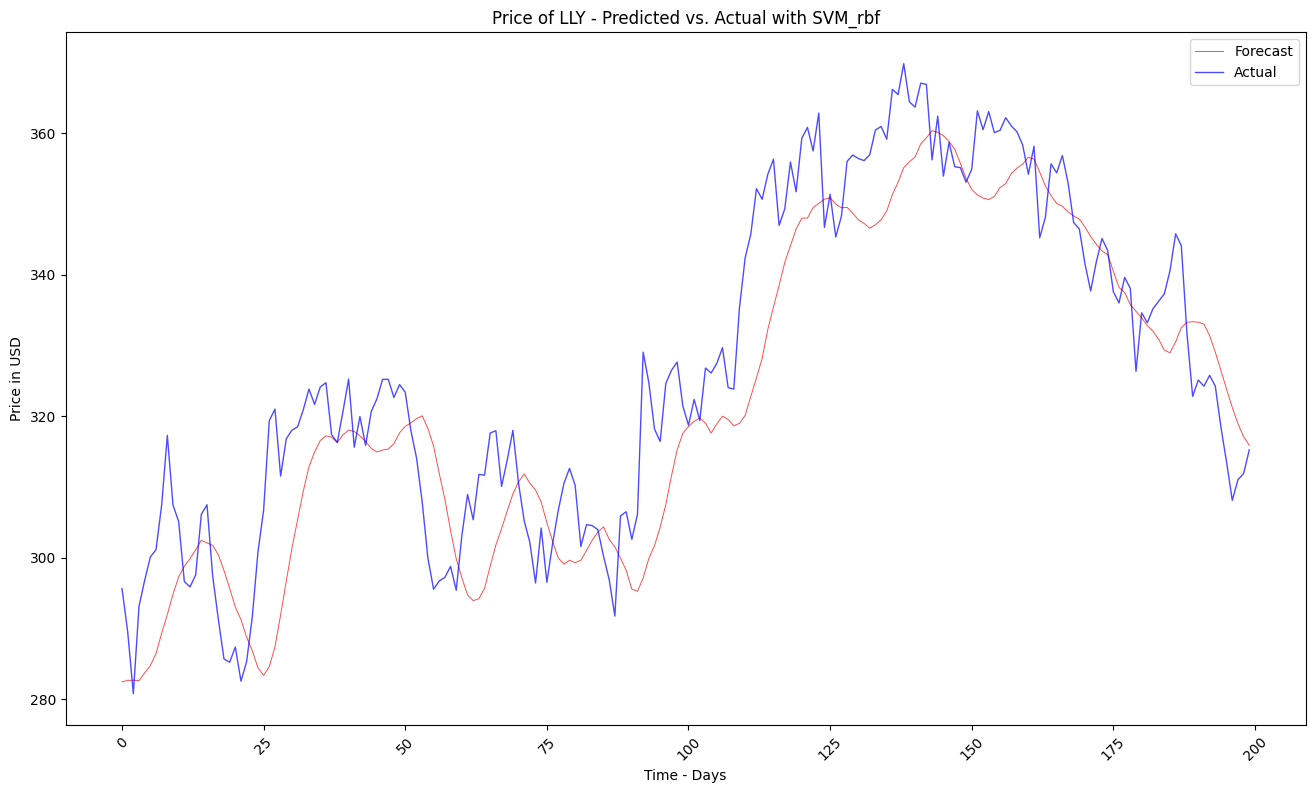

SVM model confidence score for PFE: 0.945351981328591
Mean Absolute Error for PFE: 1.2343845410129441
Mean Squared Error for PFE: 2.7518007466754315
R2 Score for PFE: 0.9334179018585117
0.945351981328591


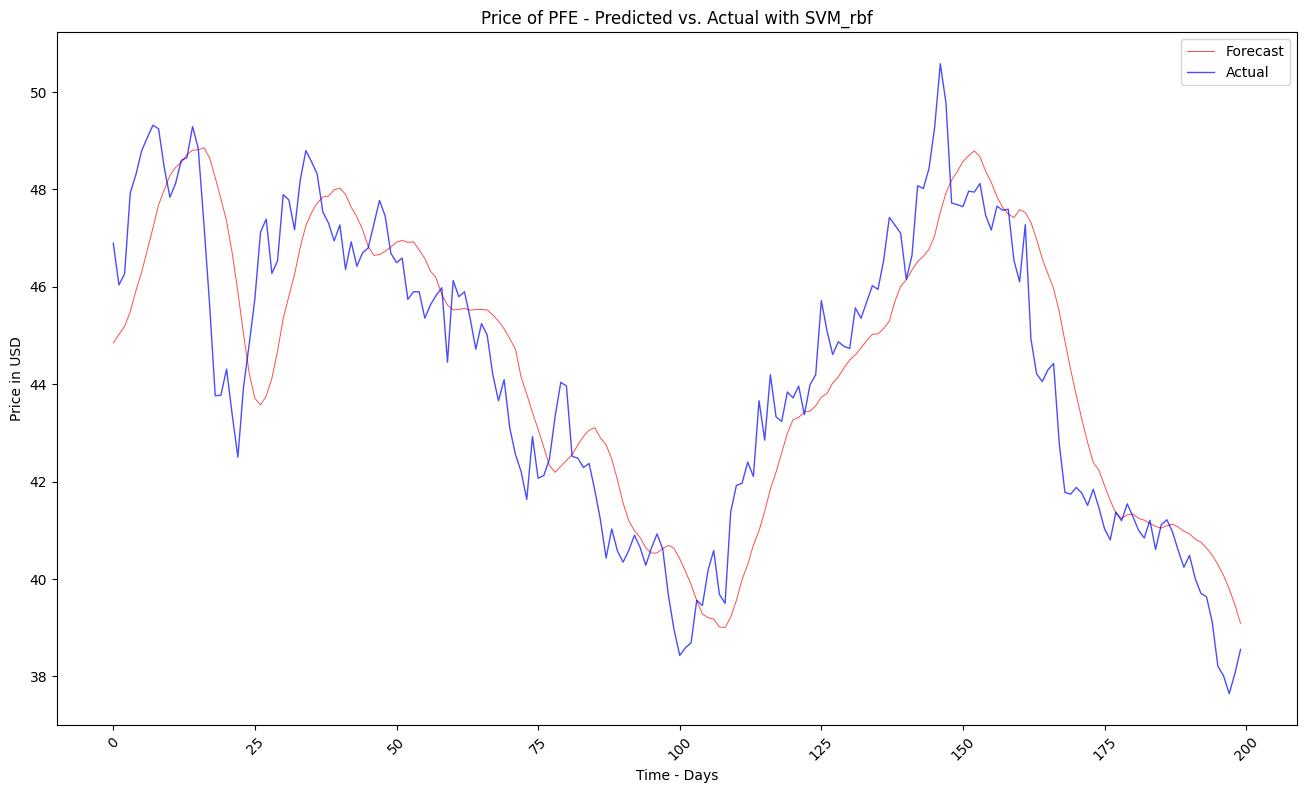

SVM model confidence score for BRK-B: 0.9418194634492808
Mean Absolute Error for BRK-B: 6.057625538634839
Mean Squared Error for BRK-B: 63.76416645169634
R2 Score for BRK-B: 0.9372949005767744
0.9418194634492808


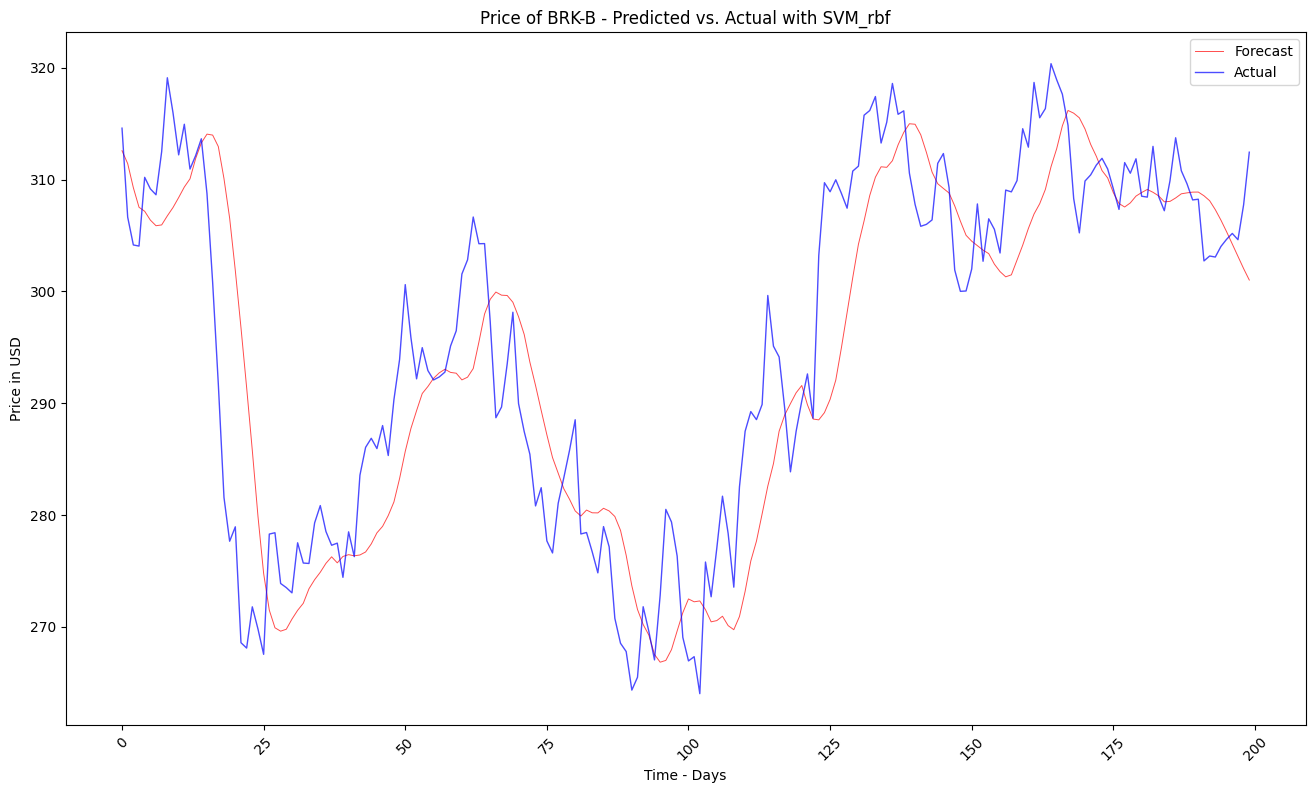

SVM model confidence score for BLK: 0.8633001374790357
Mean Absolute Error for BLK: 24.34896287579768
Mean Squared Error for BLK: 923.5820371272531
R2 Score for BLK: 0.8993176069907192
0.8633001374790357


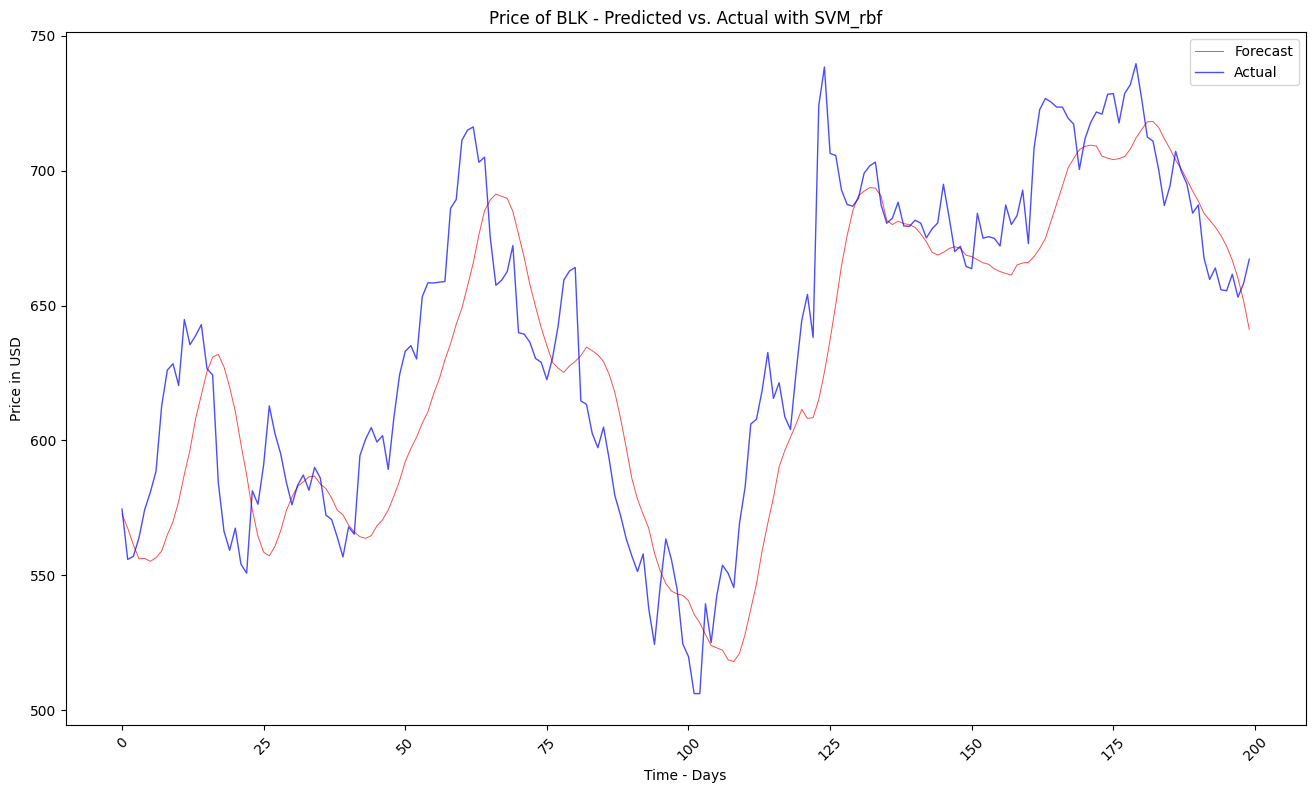

In [38]:
forecast_start_date = '2023-12-30'
forecast_end_date = '2024-10-29'
forecast_days = 5
stocks_data_prediction = yf.download(selected_stocks, start=forecast_start_date, end=forecast_end_date)

for df in adj_close_forecasts:

    feature_array = np.array(df.iloc[:, 0])
    feature_array = feature_array[:df.shape[0] - forecast_days]
    feature_array = np.reshape(feature_array, (-1, 1))
    
    target_array = np.array(df.iloc[:, 1])
    target_array = target_array[:-forecast_days]    

    #Divido i dati in set di training, validazione e test
    X_training = feature_array[:1600]
    y_training = target_array[:1600]
    X_validation = feature_array[1600:2200]
    y_validation = target_array[1600:2200]
    X_test = feature_array[2200:]
    y_test = target_array[2200:]

    #Standardizzazione dei dati
    scaler = StandardScaler()
    scaler.fit(X_training)
    x_training = scaler.transform(X_training)
    X_validation = scaler.transform(X_validation)
    X_test = scaler.transform(X_test)

    #Training del modello SVM
    svm_model = SVR(kernel='rbf', C = 1e3, gamma = 0.0001)
    svm_model.fit(x_training, y_training)

    #Valutazione del modello
    svm_model_confidence = svm_model.score(X_test, y_test)
    print(f'SVM model confidence score for {df.columns[0]}: {svm_model_confidence}')

    #Affinamento delle predizioni
    svm_predictions = svm_model.predict(X_test)
    svm_prediction_smooth = savgol_filter(svm_predictions, 15, 3)

    svm_val_predictions = svm_model.predict(X_validation)
    svm_val_predictions_smooth = savgol_filter(svm_val_predictions, 15, 3)

    #calcolo metriche di valutazione
    mae = mean_absolute_error(y_validation, svm_val_predictions)
    mse = mean_squared_error(y_validation, svm_val_predictions)
    r2 = r2_score(y_validation, svm_val_predictions)

    print(f'Mean Absolute Error for {df.columns[0]}: {mae}')
    print(f'Mean Squared Error for {df.columns[0]}: {mse}')
    print(f'R2 Score for {df.columns[0]}: {r2}')
    print(svm_model.score(X_test, y_test))

    #Grafico dei risultati
    plt.figure(figsize=(16,9))
    plt.plot(svm_val_predictions_smooth[400:], label = 'Forecast', linewidth = '0.7', color ='r', alpha = .7)
    plt.plot(y_validation[400:], label = 'Actual', linewidth = '1', color ='b', alpha = .7)
    plt.title('Price of ' f"{df.columns[0]}" ' - Predicted vs. Actual with SVM_rbf')
    plt.ylabel('Price in USD')
    plt.xlabel('Time - Days')
    plt.legend()
    plt.xticks(rotation = 45)
    plt.show()

#### Utilizzo stile ggplot

In [39]:
style.use('ggplot')

#### Creo un DataFrame per ogni ticker

In [40]:
stock_dataframes = {}

for ticker in selected_stocks:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data = stock_data.drop(columns=['High', 'Low', 'Open', 'Close'])
    stock_dataframes[f"df_{ticker}"] = stock_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


#### Creo le due serie mobili

In [41]:
for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_dataframes[dataframe_key]['SMA20'] = stock_dataframes[dataframe_key]['Adj Close'].rolling(20).mean()
    stock_dataframes[dataframe_key]['SMA120'] = stock_dataframes[dataframe_key]['Adj Close'].rolling(120).mean()

#### Mostro un grafico per ogni azione

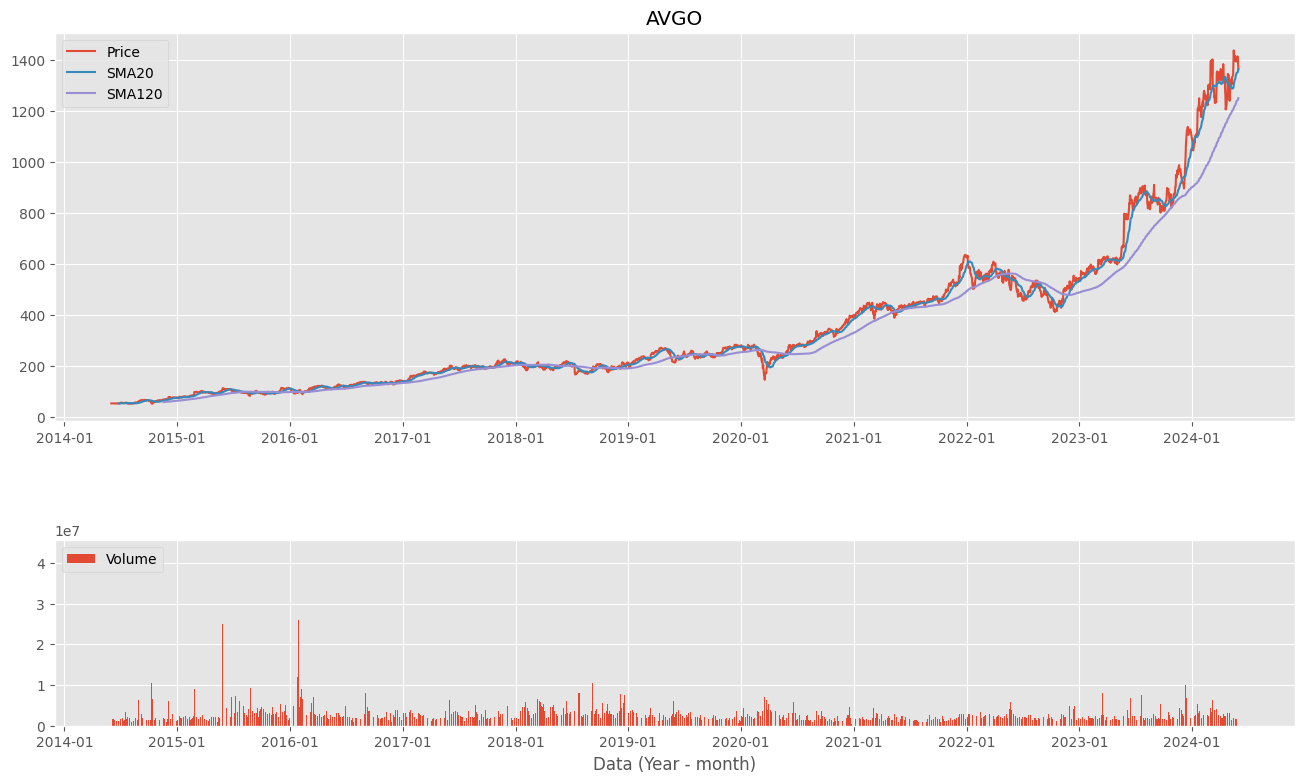

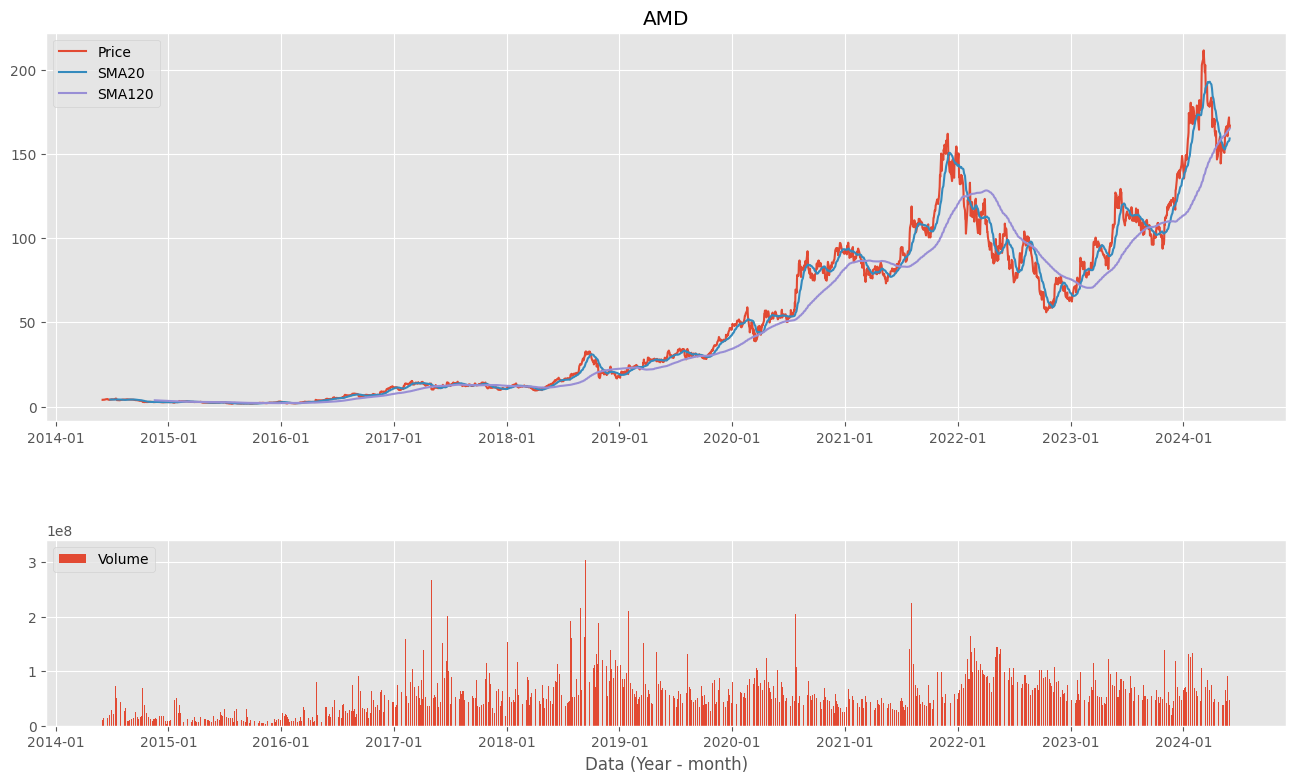

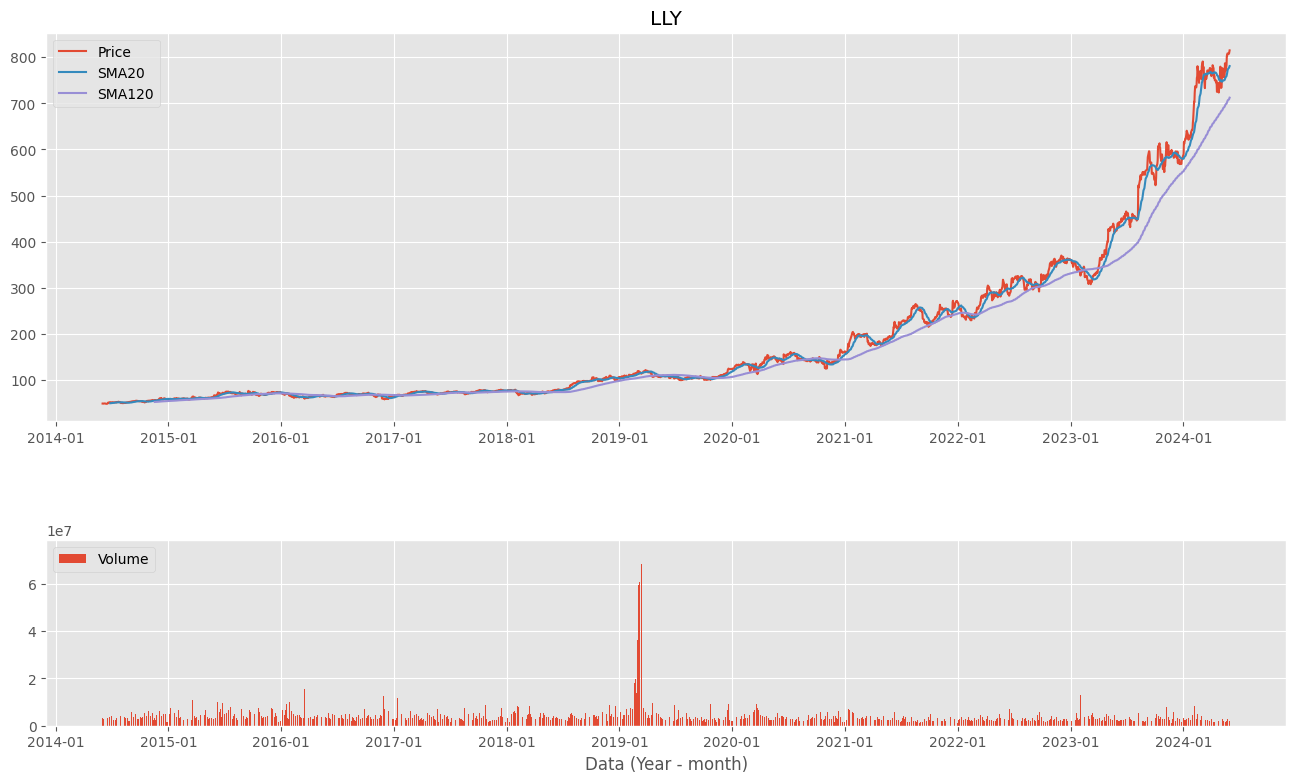

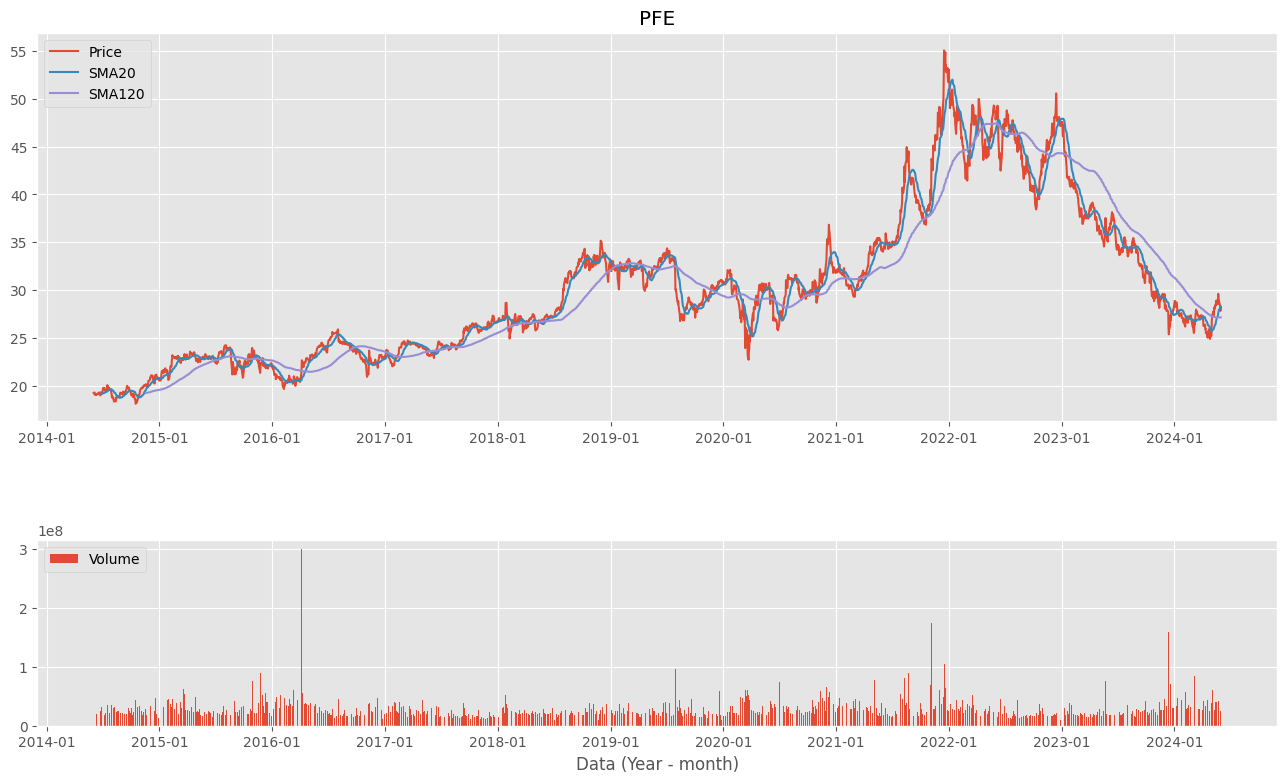

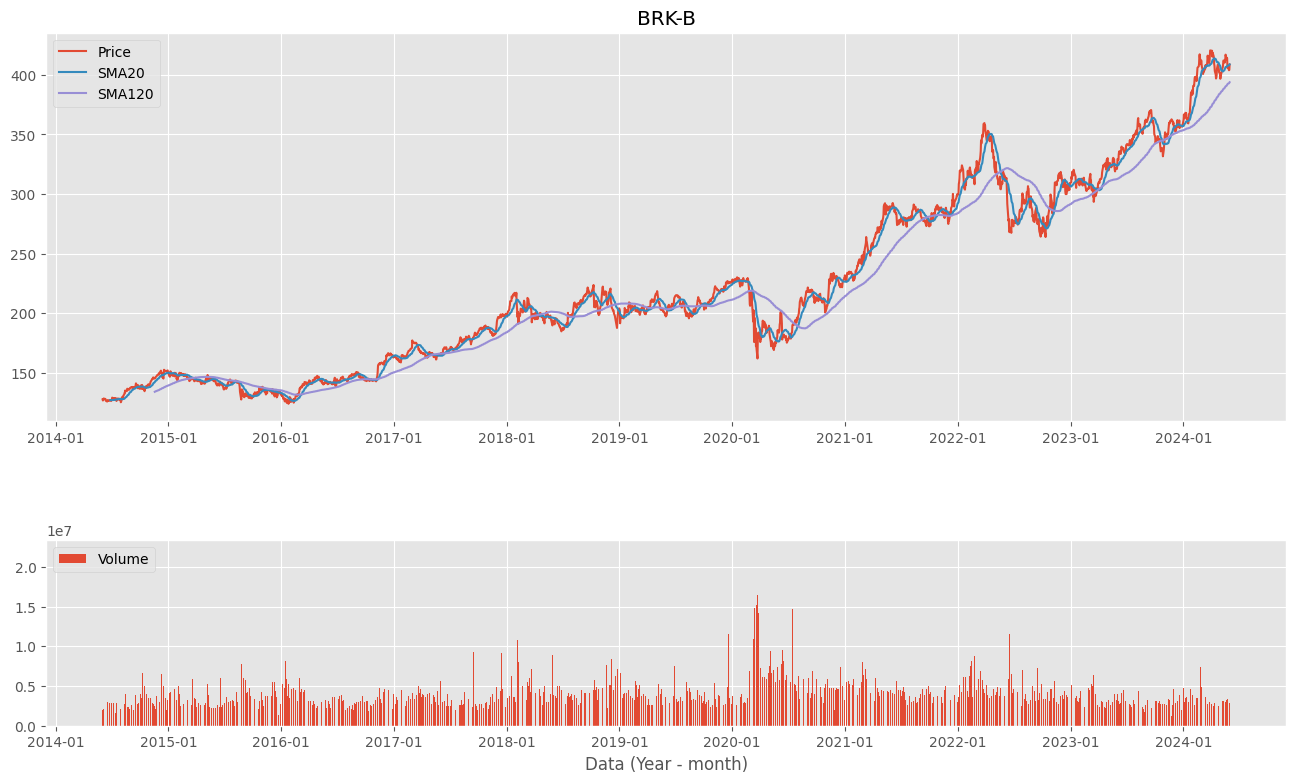

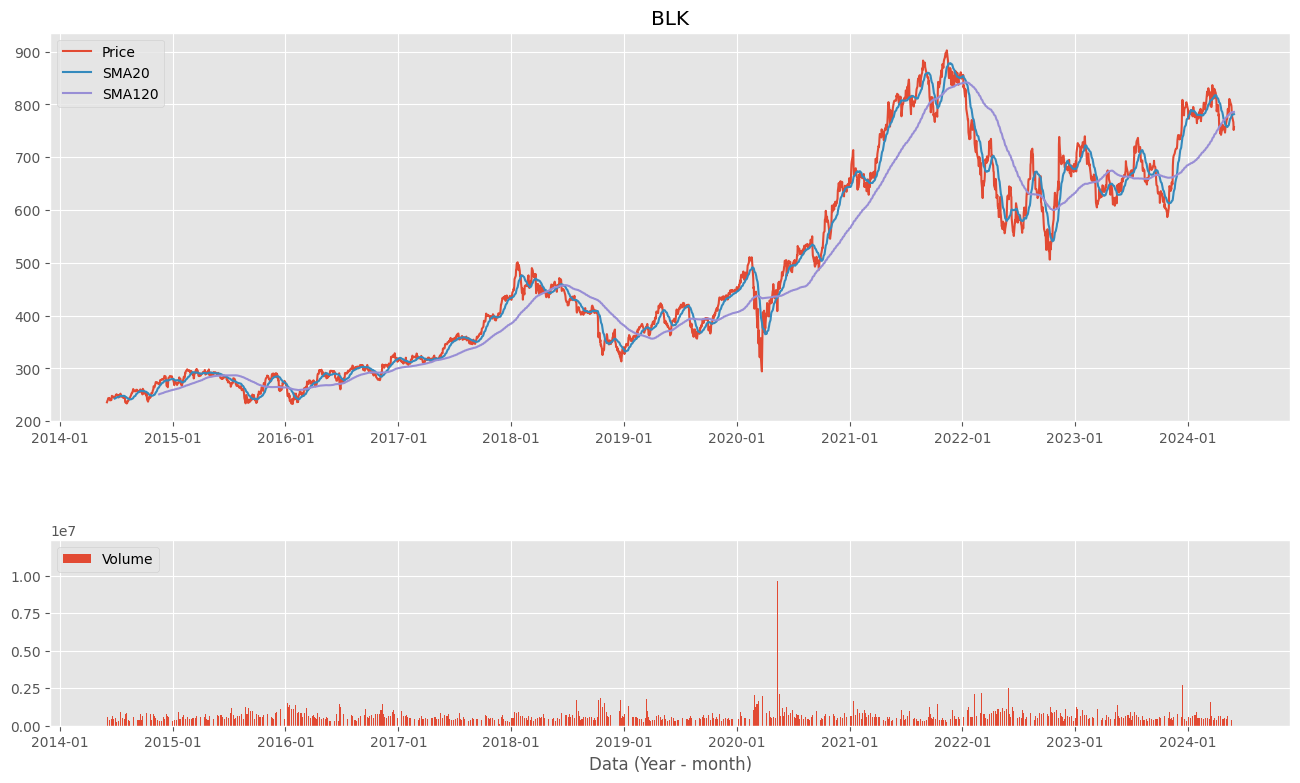

In [42]:
for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_df = stock_dataframes[dataframe_key]

    plt.figure(figsize=(16,9))
    ax1 = plt.subplot2grid((7, 1), (0, 0), rowspan=4, colspan=1, title=ticker)
    ax2 = plt.subplot2grid((7, 1), (5, 0), rowspan=2, colspan=1, sharex=ax1)

    ax1.plot(stock_df['Adj Close'], label='Price')
    ax1.plot(stock_df['SMA20'], label='SMA20')
    ax1.plot(stock_df['SMA120'], label='SMA120')

    ax2.bar(stock_df.index, stock_df['Volume'], label='Volume')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    ax2.set_xlabel('Data (Year - month)')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')

    plt.show()

#### Implemento la strategia e rendimenti

In [43]:
sma_data = {}

for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_df = stock_dataframes[dataframe_key]

    stock_df['Price_Yesterday'] = stock_df['Adj Close'].shift(1)
    stock_df['Change'] = stock_df['Adj Close'] / stock_df['Price_Yesterday']
    stock_df['Invested_SMA'] = stock_df.apply(
        lambda row: 1 if row['SMA20'] > row['SMA120'] else 0, axis=1
    )

    sma_key = f"sma_{ticker}"
    sma_data[sma_key] = stock_df[stock_df['Invested_SMA'] == 1]

#### Calcolo il prodotto cumulativo

In [44]:
sma_data[sma_key] = sma_data[sma_key].copy()
for ticker in selected_stocks:
    sma_key = f"sma_{ticker}"
    sma_data[sma_key]['Return'] = np.cumprod(sma_data[sma_key]['Change'].values)

C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_12876\3358332731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma_data[sma_key]['Return'] = np.cumprod(sma_data[sma_key]['Change'].values)
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_12876\3358332731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma_data[sma_key]['Return'] = np.cumprod(sma_data[sma_key]['Change'].values)
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_12876\3358332731.py:4: SettingWithCopyWarning: 
A

#### Calcolo ritorno medio, volatilita' annualizzata e Sharpe ratio

In [45]:
for ticker in selected_stocks:
    sma_data["sma_" + ticker].loc[:, 'rtn'] = sma_data["sma_" + ticker]['Return'].pct_change()
    sma_data["sma_" + ticker].loc[:, 'rtn'].std()*np.sqrt(252)
    sma_data["sma_" + ticker].loc[:, 'rtn'].mean()*252 / (sma_data["sma_" + ticker]['rtn'].std()*np.sqrt(252))

# Mostro un ticker di esempio
sma_data["sma_AVGO"]

C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_12876\3397941728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma_data["sma_" + ticker].loc[:, 'rtn'] = sma_data["sma_" + ticker]['Return'].pct_change()
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_12876\3397941728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma_data["sma_" + ticker].loc[:, 'rtn'] = sma_data["sma_" + ticker]['Return'].pct_change()
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_12876\3397941728.py:2

Adj Close   Volume        SMA20       SMA120  Price_Yesterday  \
Date                                                                          
2014-11-18    70.056992  2002500    65.526783    59.796917        67.842094   
2014-11-19    68.401566  1876300    65.848289    59.912917        70.056992   
2014-11-20    68.922729  1512100    66.175927    60.034464        68.401566   
2014-11-21    69.137291  1746100    66.496283    60.156786        68.922729   
2014-11-24    69.850067  1187600    66.863008    60.283399        69.137291   
...                 ...      ...          ...          ...              ...   
2024-05-23  1393.290039  3103900  1343.982507  1233.163565      1392.239990   
2024-05-24  1407.839966  1672100  1347.171008  1237.213752      1393.290039   
2024-05-28  1412.449951  2291900  1350.862506  1241.352165      1407.839966   
2024-05-29  1390.670044  2686100  1355.382507  1245.398698      1412.449951   
2024-05-30  1364.079956  2172800  1361.443506  1249.301953      1390.670044   

              Change  Invested_SMA    Return       rtn  
Date                                                    
2014-11-18  1.032648             1  1.032648       NaN  
2014-11-19  0.976370             1  1.008247 -0.023630  
2014-11-20  1.007619             1  1.015929  0.007619  
2014-11-21  1.003113             1  1.019091  0.003113  
2014-11-24  1.010310             1  1.029598  0.010310  
...              ...           ...       ...       ...  
2024-05-23  1.000754             1  9.772093  0.000754  
2024-05-24  1.010443             1  9.874141  0.010443  
2024-05-28  1.003275             1  9.906474  0.003275  
2024-05-29  0.984580             1  9.753717 -0.015420  
2024-05-30  0.980880             1  9.567223 -0.019120  

[1851 rows x 9 columns]

#### Calcolo il rendimento con strategia "Buy and Hold"

In [46]:
for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_data = stock_dataframes[dataframe_key]

    stock_data['Buy_and_hold'] = np.cumprod(stock_data['Change'])
    stock_data['rtn'] = stock_data['Buy_and_hold'].pct_change()
    daily_return_std = stock_data['rtn'].std()

#### Confronto i rendimenti

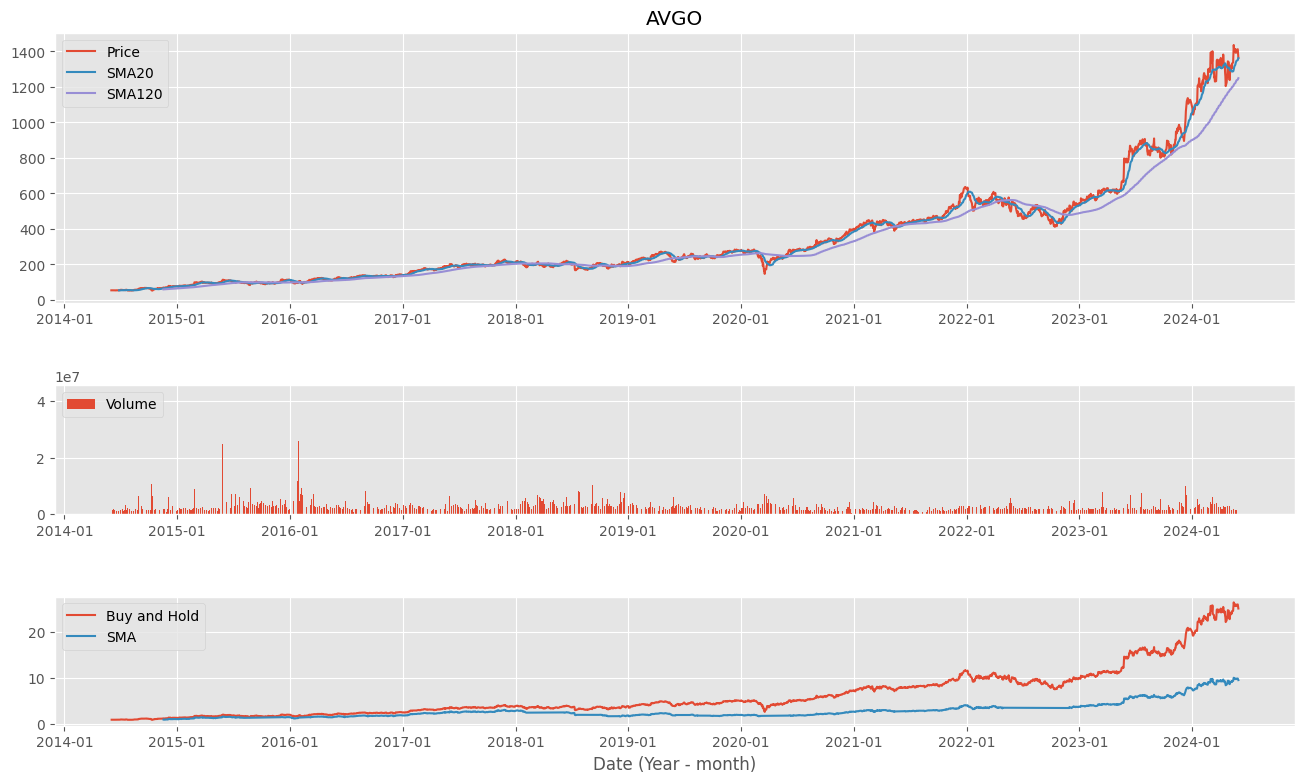

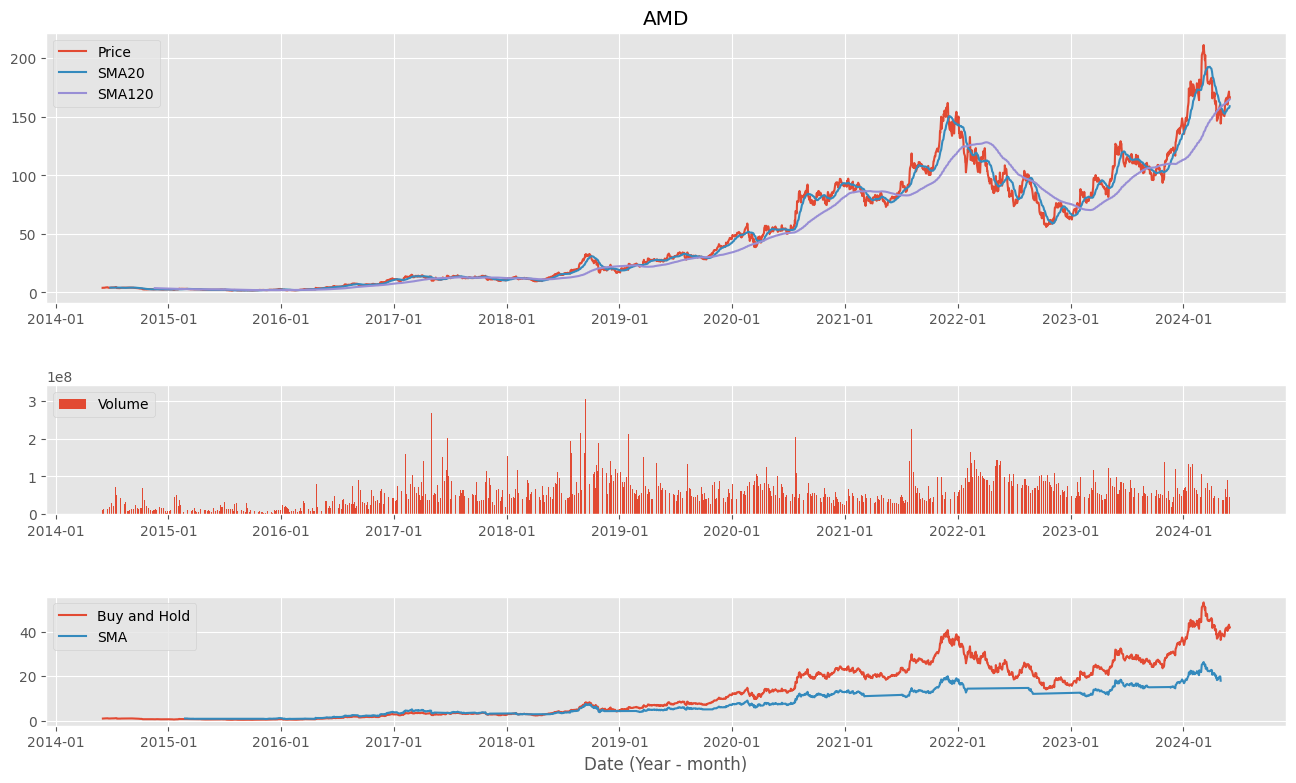

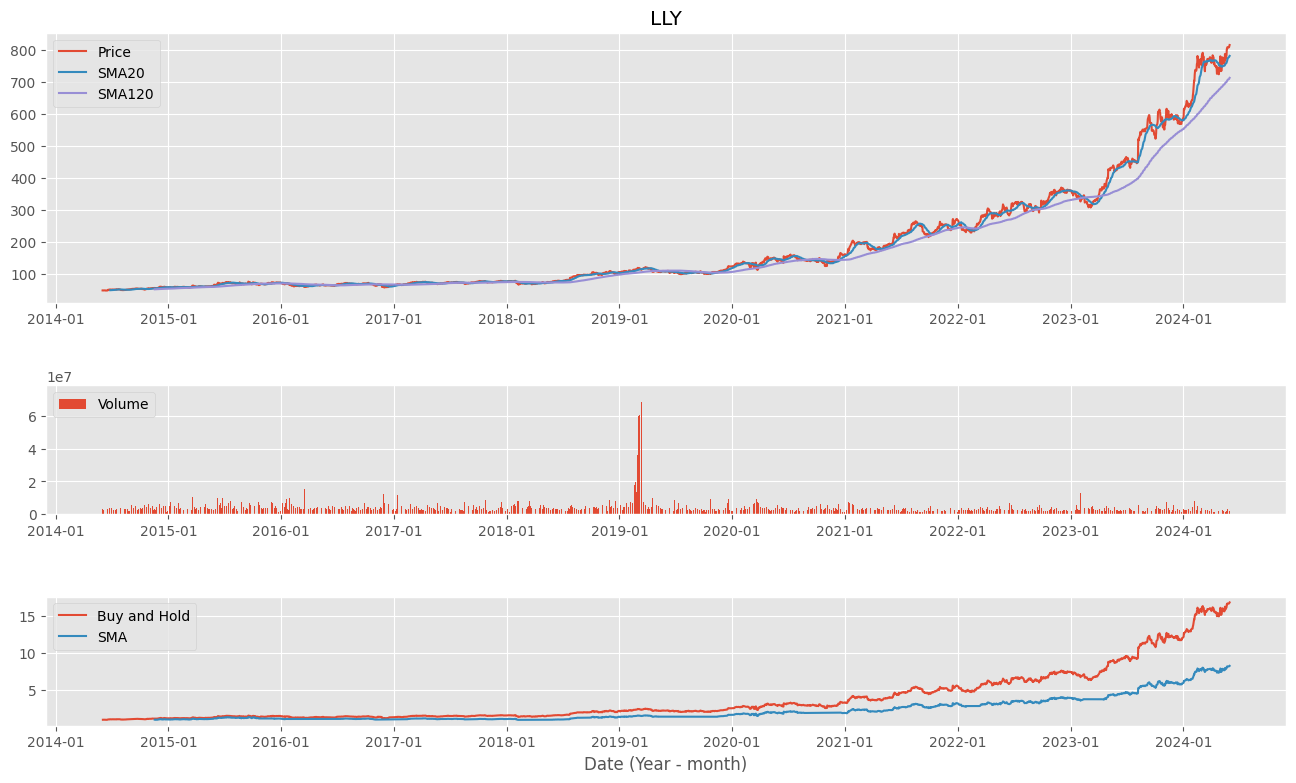

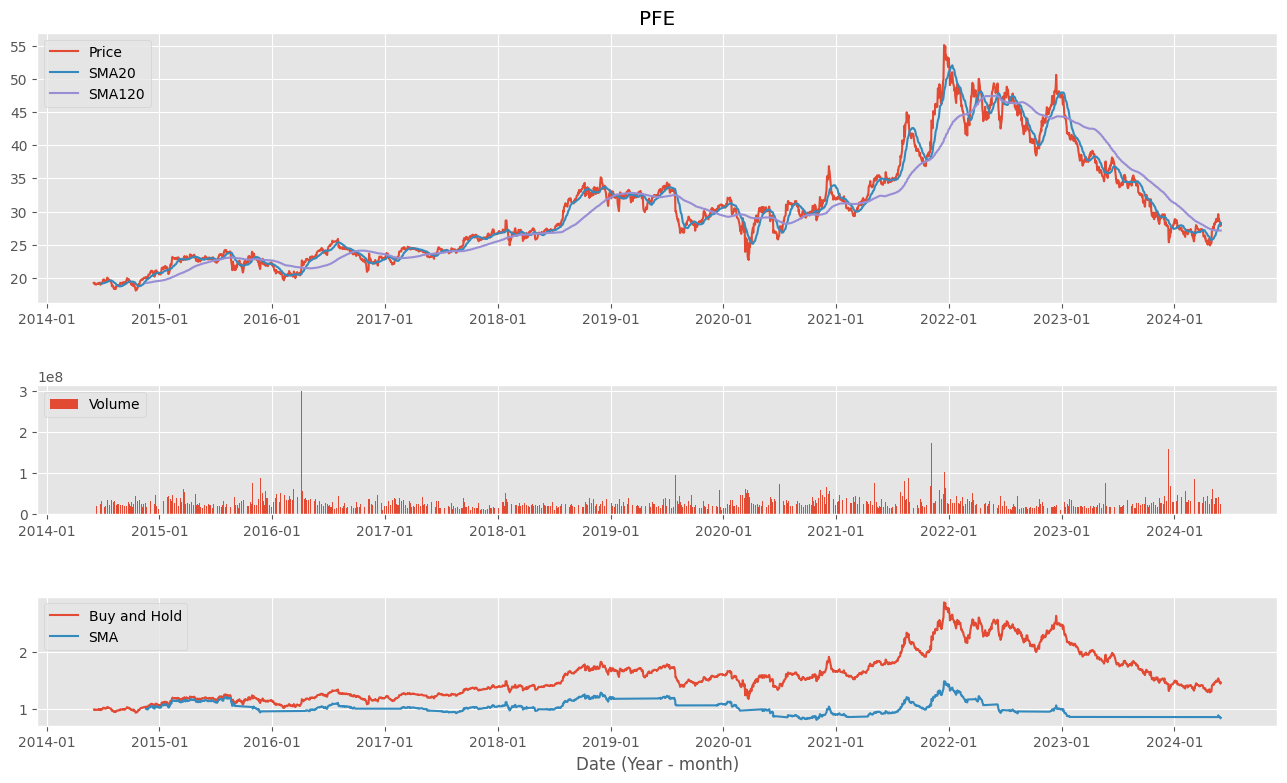

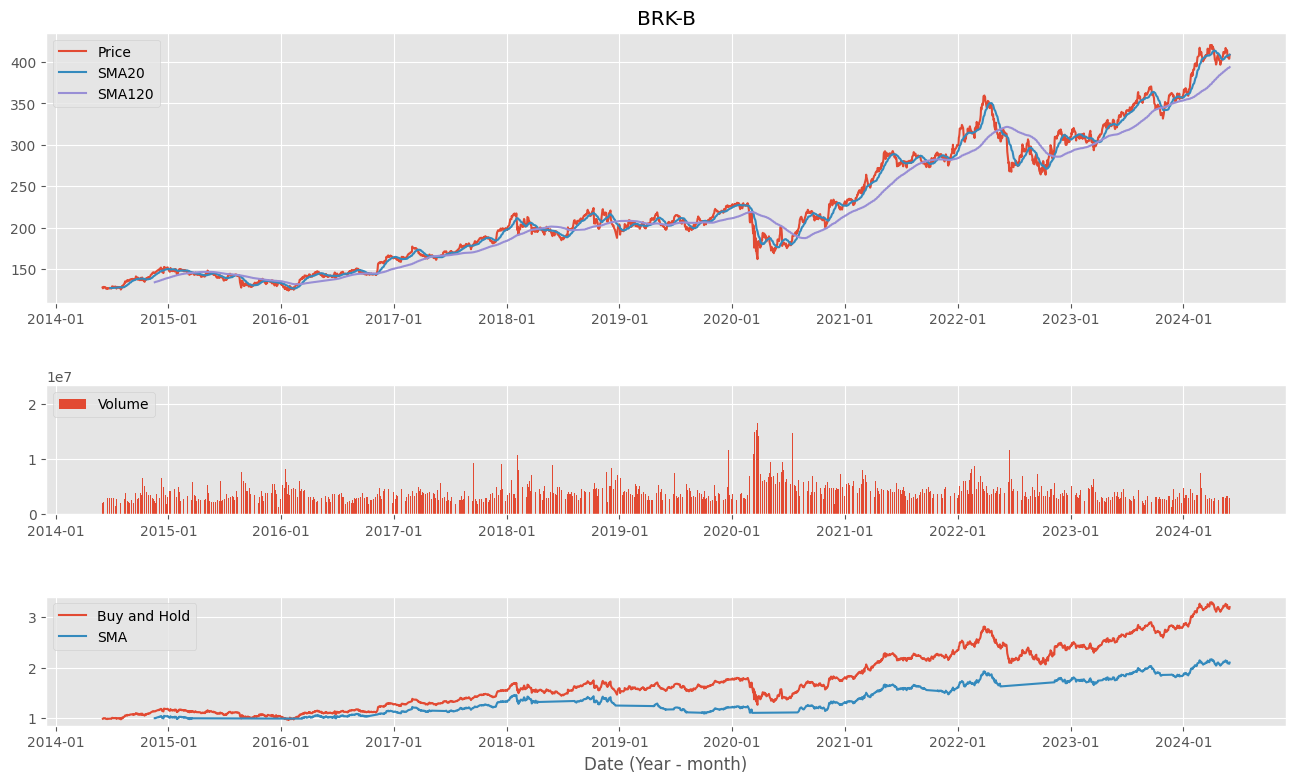

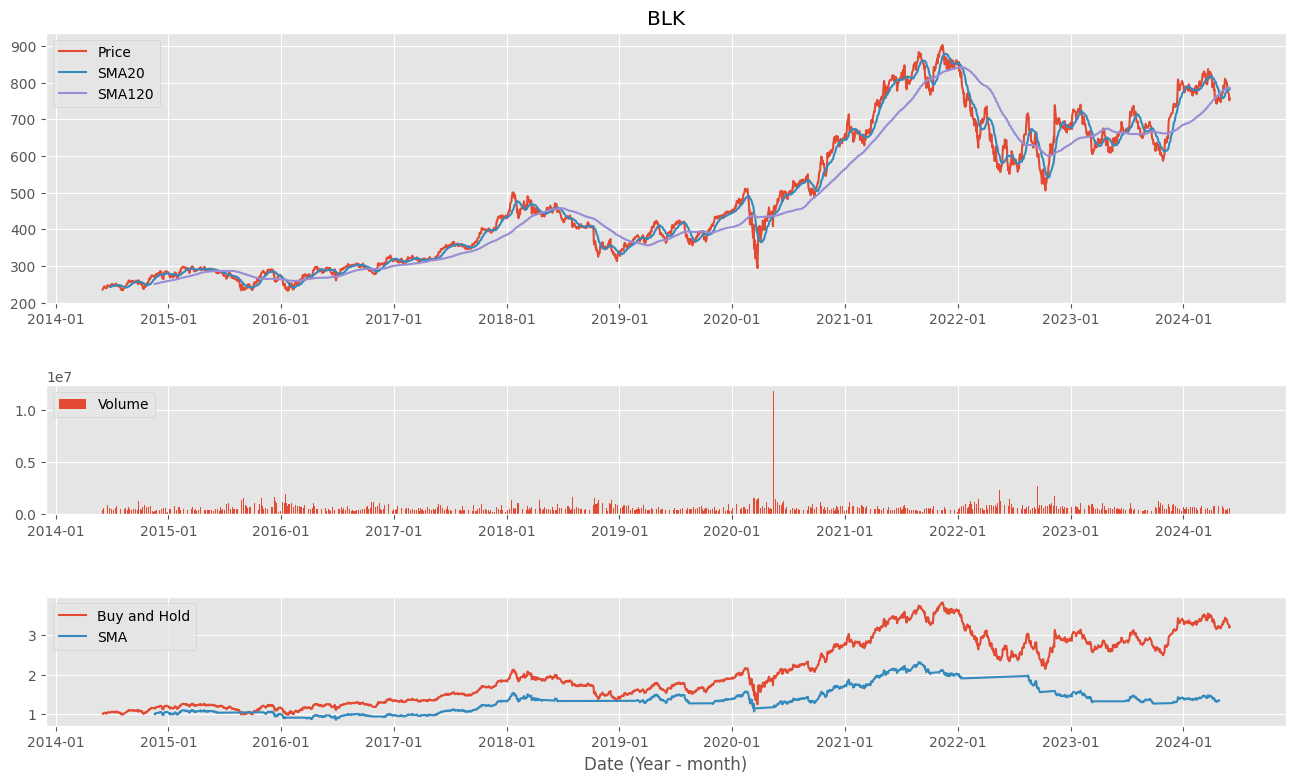

In [47]:
for ticker in selected_stocks:
    stock_data = stock_dataframes[f"df_{ticker}"]
    stock_sma_data = sma_data[f"sma_{ticker}"]


    plt.figure(figsize=(16,9))

    ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1, title=ticker)
    ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=2, colspan=1, sharex=ax1)
    ax3 = plt.subplot2grid((10, 1), (8, 0), rowspan=2, colspan=1, sharex=ax1)

    ax1.plot(stock_data['Adj Close'], label='Price')
    ax1.plot(stock_data['SMA20'], label='SMA20')
    ax1.plot(stock_data['SMA120'], label='SMA120')

    ax2.bar(stock_data.index, stock_data['Volume'], label='Volume')

    ax3.plot(stock_data['Buy_and_hold'], label='Buy and Hold')
    ax3.plot(stock_sma_data['Return'], label='SMA')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax3.set_xlabel('Date (Year - month)')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')
    ax3.legend(loc='upper left')
    plt.show()

#### Download dei dataframe con il benchmark di mercato e benchmark risk-free

In [48]:
market_benchmark = '^GSPC'
risk_free_rate = '^IRX'

capm_data = {}

for ticker in selected_stocks:
    dataframe_key = f"capm_{ticker}"
    capm_data[dataframe_key] = yf.download([ticker, market_benchmark, risk_free_rate], start=start_date, end=end_date)

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed


#### Calcolo di beta rispetto al benchmark di mercato

In [49]:
assets_beta = {}

for ticker in selected_stocks:
    beta_key = f'beta_{ticker}'
    
    capm_data_key = f'capm_{ticker}'
    capm_data_df = capm_data[capm_data_key]['Adj Close']
    capm_data_df = capm_data_df.rename(columns={ticker: 'asset', market_benchmark: 'market', risk_free_rate: 'risk_free'})
    
    capm_data_df = capm_data_df.resample('ME').mean()
    capm_data_df['mrf'] = (1 + capm_data_df['risk_free'] / 100)**(30 / 360) - 1
    capm_data_df['asset_nmr'] = capm_data_df['asset'].pct_change() - capm_data_df['mrf']
    capm_data_df['market_nmr'] = capm_data_df['market'].pct_change() - capm_data_df['mrf']

    capm_data_df.dropna(inplace=True)
    
    regression_df = capm_data_df[['asset_nmr', 'market_nmr']]
    covariance = regression_df.cov().iloc[0, 1]
    market_variance = regression_df['market_nmr'].var()
    assets_beta[beta_key] = covariance / market_variance

    y = regression_df.pop('asset_nmr')
    X = sm.add_constant(regression_df)

    model = sm.OLS(y, X).fit()
    
    print('\n' + ticker + '\n')
    print(model.summary())

for beta in assets_beta:
    print(beta + ': ', assets_beta[beta])

C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_12876\4159103230.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  capm_data_df = capm_data_df.resample('M').mean()
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_12876\4159103230.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  capm_data_df = capm_data_df.resample('M').mean()
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_12876\4159103230.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  capm_data_df = capm_data_df.resample('M').mean()



AVGO

                            OLS Regression Results                            
Dep. Variable:              asset_nmr   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     62.97
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           1.41e-12
Time:                        09:44:58   Log-Likelihood:                 172.79
No. Observations:                 119   AIC:                            -341.6
Df Residuals:                     117   BIC:                            -336.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0192      0.005      3.583  

C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_12876\4159103230.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  capm_data_df = capm_data_df.resample('M').mean()
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_12876\4159103230.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  capm_data_df = capm_data_df.resample('M').mean()
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_12876\4159103230.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  capm_data_df = capm_data_df.resample('M').mean()


#### Scarico i Data Factors

In [50]:
ff_data_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"

urllib.request.urlretrieve(ff_data_url,'fama_french.zip')

with zipfile.ZipFile('fama_french.zip', 'r') as zip_ref:
    zip_ref.extractall()

factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)

#Filtro i dati
search_string = ' Annual Factors: January-December '
matching_indices = factor_df.iloc[:, 0] == search_string
start_of_annual_index = factor_df[matching_indices].index[0]
factor_df = factor_df[factor_df.index < start_of_annual_index]

#Rinomino e formatto le colonne
factor_df.columns = ['data', 'mkt', 'smb', 'hml', 'rf']
factor_df['data'] = pd.to_datetime(factor_df['data'], format='%Y%m').dt.strftime("%Y-%m")

#### Scarico i DataFrames per Fama-French

In [51]:
fama_french_data = {}

for ticker in selected_stocks:
    dataframe_key = f"ff_df_{ticker}"
    fama_french_data[dataframe_key] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


#### Filtro la tabella con start_date e end_date

In [52]:
factor_df = factor_df.set_index('data')
factor_df = factor_df[start_date:end_date]
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)

#### Strima del modello a tre fattori

In [53]:
for ticker in selected_stocks:
    dataframe_key = f"ff_df_{ticker}"

    stock_returns = fama_french_data[dataframe_key]['Adj Close'].resample('ME').last().pct_change().dropna()
    
    stock_returns.index = stock_returns.index.strftime('%Y-%m')
    stock_returns.name = 'rtn'

    ff_data = factor_df.join(stock_returns)
    
    ff_data['excess_rtn'] = ff_data['rtn'] - ff_data['rf']

    average_risk_free_rate = ff_data['rf'].mean()
    average_market_premium = ff_data['mkt'].mean()

    ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', data=ff_data).fit()
    
    print('\n' + ticker + '\n')
    print(ff_model.summary())


AVGO

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     19.92
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           1.88e-10
Time:                        09:45:00   Log-Likelihood:                 149.73
No. Observations:                 118   AIC:                            -291.5
Df Residuals:                     114   BIC:                            -280.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0197      0.007      2.999  

#### Calcolo i rendimenti attesi per ogni asset con CAPM

In [54]:
predicted_returns = {}

for ticker in selected_stocks:
    return_key = f"rtn_{ticker}"

    expected_return = average_risk_free_rate + (assets_beta[f'beta_{ticker}'] * average_market_premium)
    annualized_expected_return = expected_return * 12
    predicted_returns[return_key] = annualized_expected_return
    print(f"{ticker}: {annualized_expected_return}")

AVGO: 0.14871092438713726
AMD: 0.25222311526498586
LLY: 0.050582750221353424
PFE: 0.08653161200187678
BRK-B: 0.10227395832616595
BLK: 0.1824056875633203


#### Scarico i prezzi e le impostazioni per il portafoglio

In [55]:
number_of_portfolios = 10 ** 5
trading_days_per_year = 252
portfolio_start_date = '2014-05-31'
portfolio_end_date = '2023-05-31'

number_of_assets = len(selected_stocks)

portfolio_data = yf.download(selected_stocks, start=portfolio_start_date, end=portfolio_end_date)

[*********************100%%**********************]  6 of 6 completed


In [56]:
returns_df = portfolio_data['Adj Close'].pct_change().dropna()
annualized_avg_returns = returns_df.mean() * trading_days_per_year
annualized_covariance_matrix = returns_df.cov() * trading_days_per_year

#### Definisco la funzione per calcolare il rendimento e la varianza di un portafoglio

In [57]:
def calculate_portfolio_return_and_variance(weights, expected_returns, covariance_matrix):
    portfolio_return = np.sum(expected_returns * weights)
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    return portfolio_return, portfolio_variance

#### Definisco la funzione per generare portafogli casuali

In [58]:
def monte_carlo_simulation(expected_returns, covariance_matrix, num_portfolios):
    num_assets = len(expected_returns)
    results = np.zeros((3, num_portfolios))
    random_weights = []

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        random_weights.append(weights)

        portfolio_return, portfolio_variance = calculate_portfolio_return_and_variance(weights, expected_returns, covariance_matrix)

        results[0, i] = portfolio_return
        results[1, i] = portfolio_variance
        results[2, i] = portfolio_return / np.sqrt(portfolio_variance)

    return results, random_weights

#### Genero i risultati e i pesi casuali

In [59]:
results, random_weights = monte_carlo_simulation(annualized_avg_returns, annualized_covariance_matrix, number_of_portfolios)

#### Calcolo i valori migliori

In [60]:
best_index = np.argmax(results[2])
best_weights = random_weights[best_index]

best_return = results[0, best_index]
best_variance = results[1, best_index]

#### Calcolo la frontiera efficiente tramite metodo Monte Carlo sui rendimenti passati

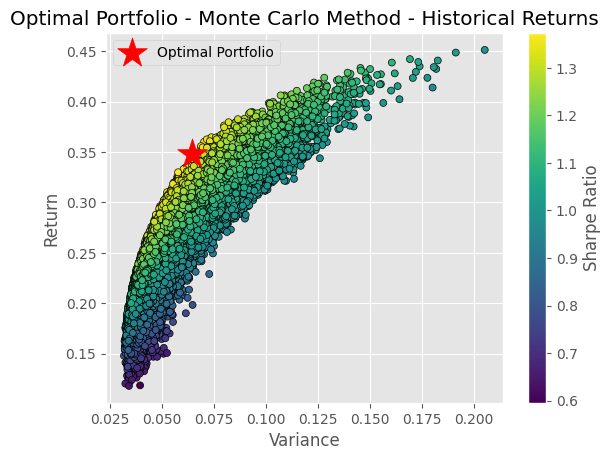

In [61]:
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', edgecolors='black', s=25)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(best_variance, best_return, marker='*', color='r', s=500, label='Optimal Portfolio')

plt.xlabel('Variance')
plt.ylabel('Return')
plt.title('Optimal Portfolio - Monte Carlo Method - Historical Returns')

plt.legend()

plt.show()

#### Calcolo la media dei rendimenti previsti

In [62]:
expected_returns = np.array(list(predicted_returns.values()))

#### Genero i risultati e i pesi casuali

In [63]:
results, random_weights = monte_carlo_simulation(expected_returns, annualized_covariance_matrix, number_of_portfolios)

#### Calcolo i valori migliori

In [64]:
best_index = np.argmax(results[2])
best_weights = random_weights[best_index]

best_return = results[0, best_index]
best_variance = results[1, best_index]

#### Calcolo la frontiera efficiente tramite metodo Monte Carlo sui rendimenti previsti

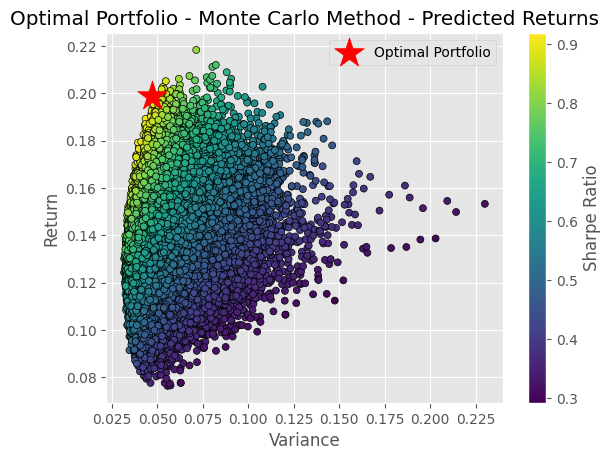

In [65]:
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', edgecolors='black', s=25)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(best_variance, best_return, marker='*', color='r', s=500, label='Optimal Portfolio')

plt.xlabel('Variance')
plt.ylabel('Return')
plt.title('Optimal Portfolio - Monte Carlo Method - Predicted Returns')

plt.legend()

plt.show()

#### Calcolo il Beta del portafoglio rispetto al mercato
- Rendimento SP500 e miglior rendimento atteso portafoglio 

In [66]:
portfolio_beta = best_return / expected_returns

print(f"Portfolio Beta: {portfolio_beta}")

Portfolio Beta: [1.33597862 0.78769392 3.92771478 2.29597728 1.94257286 1.0891909 ]
